# **ADA project**

* [Part I. Data Pre-Treatment](#PartI)    
    * [1) Pre-processing Data](#I.1)
        * [1.1) Import Data](#I.1.1)
        * [1.2) Are quotations unique?](#I.1.2)
        * [1.3) Punctuation Removal](#I.1.3)
        * [1.4) Tokenization](#I.1.4)
        * [1.5) Stop word removal](#I.1.5)
        * [1.6) Lemmatization](#I.1.6)
        * [1.7) Do we have only phase E quotations?](#I.1.7)
    * [2) Pre-analyzing Data](#2)
        * [2.1) Comparison before and after pre-processing](#I.2.1)
            * [2.1.1) Analysis about characters](#I.2.1.1)
            * [2.1.2) Analysis about words](#I.2.1.2)
        * [2.2) Selection of quotations AND comparison before and after selection](#I.2.2)
            * [2.2.1) Dropping quotations where the main speaker is "None"](#I.2.2.1)
            * [2.2.2) Dropping quotations with too weak speaker probability](#I.2.2.2)
            * [2.2.3) Dropping quotations which do not have a sufficient number of words](#I.2.3.3)
        * [2.3) Filter english text](#I.2.3)
        * [2.4) Final adjustments](#I.2.4)
* [Part II. Tools for our project about Trump](#PartII) 
    * [1) Data](#II.1)
    * [2) LDA function](#II.2)
    * [3) Sentiment analysis](#II.3)
        * [3.1) Flair](#II.3.1)
        * [3.2) VaderSentiment](#II.3.2)
    * [4) Additional data](#II.4)
* [Part III. Our project about Trump](#PartIII) 
    * [Question 4: Can we quantify Trump popularity over time and correlate it with external events? Can we see the impact of his speech on the population (different groups of population?)?](#III.4)
        * [4.1) Trump popularity over time](#III.4.1)
        * [4.2) Trump popularity and population groups](#III.4.2)
    
    


In [3]:
import bz2
import json
import pandas as pd
import string
import re
import nltk
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import pickle
import langdetect
import flair
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from urllib.parse import urlparse
from matplotlib.pyplot import figure

# Part I. Data Pre-Treatment <a class="anchor" id="PartI"></a>

## 1) Pre-processing Data  <a class="anchor" id="I.1"></a>

### 1.1) Import Data  <a class="anchor" id="I.1.1"></a>

To avoid having to download and import all the data in this Jupyter Notebook, we opened all the data on Google Colab from Google Drive (cf. Mounting Google Drive) and we retrieved only the data that interested us for our project. We end up with two bz2 files: a file where Trump is the speaker and a file where the word "trump" appears in the quotation. The code used on Google Colab is the following:

```
import bz2
import json

input_files = [f'/content/drive/MyDrive/Quotebank/quotes-20{i}.json.bz2' for i in range(15, 21)]
file_about_trump = '/content/quotes-about-trump.json.bz2'
file_from_trump = '/content/quotes-from-trump.json.bz2'

for input_file in input_files:
    with bz2.open(input_file, 'rb') as s_file:
        about_file = bz2.open(file_about_trump, 'ab')
        from_file = bz2.open(file_from_trump, 'wb')
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            trump_speaking = instance['speaker'].lower().__contains__('trump')
            about_trump = instance['quotation'].lower().__contains__('trump')
            if trump_speaking:
                from_file.write((json.dumps(instance)+'\n').encode('utf-8'))
            elif about_trump:
                about_file.write((json.dumps(instance)+'\n').encode('utf-8'))
        about_file.close()
        from_file.close()

```

We open the first file where Trump is the speaker:

In [6]:
data = []
with bz2.open('data/quotes-from-trump.json.bz2', "rt") as data_file :
    for line in data_file :
        try :
            lignedata = json.loads(line)
            data.append(lignedata)
        except:
            continue

df_from = pd.DataFrame()

df_from["quoteID"] = list(map(lambda d : d["quoteID"], data))
df_from["quotation"] = list(map(lambda d : d["quotation"], data))
df_from["speaker"] = list(map(lambda d : d["speaker"], data))
df_from["qids"] = list(map(lambda d : d["qids"], data))
df_from["date"] = list(map(lambda d : d["date"], data))
df_from["numOccurrences"] = list(map(lambda d : d["numOccurrences"], data))
df_from["probas"] = list(map(lambda d : d["probas"], data))
df_from["urls"] = list(map(lambda d : d["urls"], data))
df_from["phase"] = list(map(lambda d : d["phase"], data))

df_from.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-07-17-029255,I am incredibly pleased that my message is res...,Donald Trump,"[Q22686, Q27947481]",2015-07-17 10:28:58,2,"[[Donald Trump, 0.8415], [None, 0.1356], [Rand...",[http://washingtontimes.com/news/2015/jul/17/d...,E
1,2015-12-10-038891,I don't want this person representing either t...,Donald Trump,"[Q22686, Q27947481]",2015-12-10 16:20:00,1,"[[Donald Trump, 0.509], [None, 0.491]]",[http://www.westernmorningnews.co.uk/Petition-...,E
2,2015-11-14-003251,And I will tell you what -- you can say what y...,Donald Trump,"[Q22686, Q27947481]",2015-11-14 22:45:14,6,"[[Donald Trump, 0.798], [None, 0.202]]",[http://news.yahoo.com/paris-wouldve-different...,E
3,2015-10-07-007656,angry at our leaders for not knowing what's ha...,Donald Trump,"[Q22686, Q27947481]",2015-10-07 19:18:48,1,"[[Donald Trump, 0.9064], [None, 0.0936]]",[http://www.radioiowa.com/2015/10/07/trump-rap...,E
4,2015-09-20-019882,I never called Jeb Bush and I never asked him ...,Donald Trump,"[Q22686, Q27947481]",2015-09-20 14:01:28,2,"[[Donald Trump, 0.5131], [None, 0.459], [Jeb B...",[http://tpmdc.talkingpointsmemo.com/livewire/d...,E


In [7]:
# Checking that the speaker is correct
print(df_from.speaker.unique())

['Donald Trump' 'DONALD Trump' 'DONALD TRUMP' 'President Donald Trump'
 'Donald J. Trump' 'Ivanka Trump' 'Andreas Trumpp' 'President Trump'
 'donald trump' 'Ivana Trump' 'Donald Trump Jr. .' 'Donnie Trumpet'
 'Melania Trump' 'Joan Trumpauer Mulholland' 'Judd Trump' 'Eric Trump'
 'Donald John Trump' 'Melania Knauss-Trump' 'president Trump'
 'Melania trump' 'PRESIDENT TRUMP' 'Donald trump' 'JUDD TRUMP'
 'Barron Trump' 'Tiffany Trump' 'Donald Trump , Jr. .'
 'president Donald Trump' 'Maryanne Trump Barry' 'Lara Trump'
 'President Donald J. Trump' 'Lara trump' 'Bob Trumpy' 'William Trump'
 'Trumpet Black' 'Donald Trump Jr' 'Baroness Trumpington'
 'Elizabeth Trump' 'MELANIA TRUMP' 'Donald J Trump' 'Blaine Trump'
 'Simon Trumper' 'Donald L. Trump' 'DOnald Trump' 'Vanessa Trump'
 'Timmy Trumpet' 'Jean Barker , Baroness Trumpington' 'DONALD J. TRUMP'
 'Tiffany Ariana Trump' 'ivanka trump' 'President Donald John Trump'
 'melania trump' 'IVANKA TRUMP' 'Donald J. Trump Jr. .'
 'president Donald J

In [8]:
# Fixing the speaker so that we only have quotes spoken by Donald Trump
num_quotes_before = len(df_from)
df_from = df_from[df_from.speaker.str.lower().isin(["donald trump", "president donald trump", "president trump", "donald j. trump", "president donald j. trump", "donald j trump", "donald john trump", "president donald john trump"])]
num_quotes_after = len(df_from)

print(f"Removed {round((num_quotes_before-num_quotes_after)/num_quotes_before*100, 1)}% of quotes")

Removed 7.1% of quotes


Secondly, we open the second file where the quotation is about Trump:

We made the choice to select the quotes about Trump in a quite general way (contains 'trump') so as not to lose too many quotes. We are aware that some of those quotes will not actually be about Donald Trump but we expect that those will not influence the results much.

In [9]:
data = []
with bz2.open('data/quotes-about-trump.json.bz2', "rt") as data_file :
    for line in data_file :
        try :
            lignedata = json.loads(line)
            data.append(lignedata)
        except:
            continue

df_about = pd.DataFrame()

df_about["quoteID"] = list(map(lambda d : d["quoteID"], data))
df_about["quotation"] = list(map(lambda d : d["quotation"], data))
df_about["speaker"] = list(map(lambda d : d["speaker"], data))
df_about["qids"] = list(map(lambda d : d["qids"], data))
df_about["date"] = list(map(lambda d : d["date"], data))
df_about["numOccurrences"] = list(map(lambda d : d["numOccurrences"], data))
df_about["probas"] = list(map(lambda d : d["probas"], data))
df_about["urls"] = list(map(lambda d : d["urls"], data))
df_about["phase"] = list(map(lambda d : d["phase"], data))

df_about.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E
3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E
4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E


Finally we combine the two dataframes in a single one:

In [10]:
# Concatenate the two DataFrame in a single one for pre-processing
df = pd.concat([df_about, df_from], axis=0)

df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E
3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E
4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E


### 1.2) Are quotations unique?  <a class="anchor" id="I.1.2"></a>

In [11]:
print(f"Are quotations unique? {df.quotation.is_unique}")

Are quotations unique? True


### 1.3) Punctuation Removal  <a class="anchor" id="I.1.3"></a>

Removing punctuation because it doesn't add semantic meaning

In [12]:
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

df['quote_punctfree']= df['quotation'].apply(lambda x: remove_punctuation(x))

df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,quote_punctfree
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E,How long do you think itll take for Donald Tru...
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,And Im just pointing out the absurd on both si...
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,And you had Michael Jackson roller skating and...
3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E,I like that hes not spinning things He seems g...
4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,I promise I wont talk about Trump again


### 1.4) Tokenization  <a class="anchor" id="I.1.4"></a>

In [13]:
def tokenization(text):
    tokens = re.split('\W+',text)
    return tokens

df['quote_punctfree_token']= df['quote_punctfree'].apply(lambda x: tokenization(x))

df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,quote_punctfree,quote_punctfree_token
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E,How long do you think itll take for Donald Tru...,"[How, long, do, you, think, itll, take, for, D..."
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,And Im just pointing out the absurd on both si...,"[And, Im, just, pointing, out, the, absurd, on..."
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,And you had Michael Jackson roller skating and...,"[And, you, had, Michael, Jackson, roller, skat..."
3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E,I like that hes not spinning things He seems g...,"[I, like, that, hes, not, spinning, things, He..."
4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,I promise I wont talk about Trump again,"[I, promise, I, wont, talk, about, Trump, again]"


### 1.5) Stop word removal  <a class="anchor" id="I.1.6"></a>

We chose to use as stopwords words in the english language which don't add much semantic meaning. 

In [14]:
# Stop words present in the library
nltk.download('stopwords')
stopwords = [s.replace("'", "") for s in nltk.corpus.stopwords.words('english')] # removing apostrophes from stopwords
print(stopwords) # checking that we don't remove useful words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thatll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\felic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def remove_stopwords(text):
    output = [i for i in text if i not in stopwords]
    return output

df['quote_punctfree_token_NoStopWord'] = df['quote_punctfree_token'].apply(lambda x: remove_stopwords(x))

df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,quote_punctfree,quote_punctfree_token,quote_punctfree_token_NoStopWord
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E,How long do you think itll take for Donald Tru...,"[How, long, do, you, think, itll, take, for, D...","[How, long, think, itll, take, Donald, Trump, ..."
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,And Im just pointing out the absurd on both si...,"[And, Im, just, pointing, out, the, absurd, on...","[And, Im, pointing, absurd, sides, Im, sidetak..."
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,And you had Michael Jackson roller skating and...,"[And, you, had, Michael, Jackson, roller, skat...","[And, Michael, Jackson, roller, skating, Donal..."
3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E,I like that hes not spinning things He seems g...,"[I, like, that, hes, not, spinning, things, He...","[I, like, hes, spinning, things, He, seems, ge..."
4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,I promise I wont talk about Trump again,"[I, promise, I, wont, talk, about, Trump, again]","[I, promise, I, talk, Trump]"


We also made a function to find the words which occur in the most quotes. We do not use it yet, but if the topics are not being extracted well then we can use this to remove the most frequent words as well.

In [16]:
# Function for getting the frequency of quotes in which words appear
def get_doc_frequency(data):
    joined_data = " ".join(data)
    words = {w: set() for w in set(joined_data.split())}
    for i, vote in enumerate(data):
        for w in vote.split():
            if w in words:
                words[w].add(i)
    
    data_len = len([d for d in data if d != ''])
    words = sorted({w: len(words[w])/data_len for w in words}.items(), key=lambda x: -x[1])
    return words

In [17]:
get_doc_frequency([" ".join(q) for q in list(df['quote_punctfree_token_NoStopWord'])])[:20] # most frequent words

[('Trump', 0.47321455127734313),
 ('I', 0.21698171044461023),
 ('Donald', 0.131514110048117),
 ('President', 0.11906815592405928),
 ('The', 0.10000345990726235),
 ('people', 0.0901014481229396),
 ('Trumps', 0.08879457437981163),
 ('going', 0.06862270803906417),
 ('think', 0.06519132983660132),
 ('would', 0.06492667728109561),
 ('We', 0.06323799973656145),
 ('like', 0.05986974966660455),
 ('And', 0.05096443397434691),
 ('know', 0.04912097110491835),
 ('one', 0.04672453007478863),
 ('get', 0.04294776814736534),
 ('country', 0.04182967180048111),
 ('president', 0.04079655563197027),
 ('said', 0.04059442420769641),
 ('want', 0.04015252728015476)]

### 1.6) Lemmatization  <a class="anchor" id="I.1.7"></a>

We are not sure if this will improve our results so we will try with and without and see which works best.

In [18]:
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

df['quote_punctfree_token_NoStopWord_lemm'] = df['quote_punctfree_token_NoStopWord'].apply(lambda x: lemmatizer(x))
df['final_quote'] = df['quote_punctfree_token_NoStopWord_lemm']

df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\felic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,quote_punctfree,quote_punctfree_token,quote_punctfree_token_NoStopWord,quote_punctfree_token_NoStopWord_lemm,final_quote
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E,How long do you think itll take for Donald Tru...,"[How, long, do, you, think, itll, take, for, D...","[How, long, think, itll, take, Donald, Trump, ...","[How, long, think, itll, take, Donald, Trump, ...","[How, long, think, itll, take, Donald, Trump, ..."
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,And Im just pointing out the absurd on both si...,"[And, Im, just, pointing, out, the, absurd, on...","[And, Im, pointing, absurd, sides, Im, sidetak...","[And, Im, pointing, absurd, side, Im, sidetaki...","[And, Im, pointing, absurd, side, Im, sidetaki..."
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,And you had Michael Jackson roller skating and...,"[And, you, had, Michael, Jackson, roller, skat...","[And, Michael, Jackson, roller, skating, Donal...","[And, Michael, Jackson, roller, skating, Donal...","[And, Michael, Jackson, roller, skating, Donal..."
3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E,I like that hes not spinning things He seems g...,"[I, like, that, hes, not, spinning, things, He...","[I, like, hes, spinning, things, He, seems, ge...","[I, like, he, spinning, thing, He, seems, genu...","[I, like, he, spinning, thing, He, seems, genu..."
4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,I promise I wont talk about Trump again,"[I, promise, I, wont, talk, about, Trump, again]","[I, promise, I, talk, Trump]","[I, promise, I, talk, Trump]","[I, promise, I, talk, Trump]"


### 1.8) Do we have only phase E quotations?  <a class="anchor" id="1.8"></a>

Phase E is good because it is more precise than the other phases.

In [19]:
df.groupby(df.phase).agg('count')

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,quote_punctfree,quote_punctfree_token,quote_punctfree_token_NoStopWord,quote_punctfree_token_NoStopWord_lemm,final_quote
phase,,,,,,,,,,,,,
E,1647515,1647515,1647515,1647515,1647515,1647515,1647515,1647515,1647515,1647515,1647515,1647515,1647515


## 2) Pre-analyzing Data  <a class="anchor" id="I.2"></a>

### 2.1) Comparison before and after pre-processing  <a class="anchor" id="I.2.1"></a>

#### 2.1.1) Analysis about characters  <a class="anchor" id="I.2.1.1"></a>

In [20]:
# Creation of a new table for the analysis
analyze = df.loc[:, ['quoteID', 'quotation', 'final_quote']].copy(deep=True)

In [21]:
# Creation of a new column with the number of characters per citation (spaces included)
analyze["ch_quote"] = analyze["quotation"].apply(lambda x: len(x))

analyze.head()

,quoteID,quotation,final_quote,ch_quote
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,"[How, long, think, itll, take, Donald, Trump, ...",113
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,"[And, Im, pointing, absurd, side, Im, sidetaki...",407
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...","[And, Michael, Jackson, roller, skating, Donal...",61
3,2015-10-20-044420,I like that he's not spinning things. He seems...,"[I, like, he, spinning, thing, He, seems, genu...",148
4,2015-12-22-031341,"I promise, I won't talk about Trump again,","[I, promise, I, talk, Trump]",42


In [22]:
# Creation of a new column with the number of characters of the final quote without tokenization
analyze["ch_final_quote"] = (df["final_quote"].apply(lambda x: ' '.join(x))).apply(lambda x: len(x))

analyze.head()

,quoteID,quotation,final_quote,ch_quote,ch_final_quote
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,"[How, long, think, itll, take, Donald, Trump, ...",113,77
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,"[And, Im, pointing, absurd, side, Im, sidetaki...",407,291
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...","[And, Michael, Jackson, roller, skating, Donal...",61,47
3,2015-10-20-044420,I like that he's not spinning things. He seems...,"[I, like, he, spinning, thing, He, seems, genu...",148,89
4,2015-12-22-031341,"I promise, I won't talk about Trump again,","[I, promise, I, talk, Trump]",42,22


In [23]:
# Creation of a new column with the percentage of characters removed after pre-processing
analyze["ch_removed"] = (analyze["ch_quote"]-analyze["ch_final_quote"])*100/analyze["ch_quote"]

analyze.head()

,quoteID,quotation,final_quote,ch_quote,ch_final_quote,ch_removed
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,"[How, long, think, itll, take, Donald, Trump, ...",113,77,31.858407
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,"[And, Im, pointing, absurd, side, Im, sidetaki...",407,291,28.501229
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...","[And, Michael, Jackson, roller, skating, Donal...",61,47,22.950820
3,2015-10-20-044420,I like that he's not spinning things. He seems...,"[I, like, he, spinning, thing, He, seems, genu...",148,89,39.864865
4,2015-12-22-031341,"I promise, I won't talk about Trump again,","[I, promise, I, talk, Trump]",42,22,47.619048


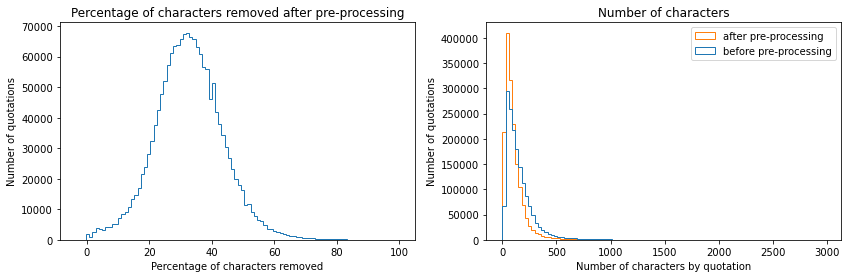

In [24]:
# Plot the distribution of the number of characters by quotation before pre-processing data and after pre-processing data
# And plot of the distribution of the percentage of characters removed after pre-processing

fig, ax = plt.subplots(1,2,figsize=(14,4))

ax[0].hist(analyze.ch_removed, bins=100, histtype='step')
ax[0].set_title('Percentage of characters removed after pre-processing')
ax[0].set_xlabel('Percentage of characters removed')
ax[0].set_ylabel('Number of quotations')

ax[1].hist([analyze.ch_quote, analyze.ch_final_quote], bins=100, histtype='step', label=['before pre-processing', 'after pre-processing'])
ax[1].set_title('Number of characters')
ax[1].set_xlabel('Number of characters by quotation')
ax[1].set_ylabel('Number of quotations')

plt.legend()
plt.show()

In [25]:
# Describe the column about the percentage of characters removed
analyze.ch_removed.describe()

count    1.647515e+06
mean     3.265374e+01
std      1.090174e+01
min     -3.448276e+00
25%      2.571429e+01
50%      3.239437e+01
75%      3.935018e+01
max      1.000000e+02
Name: ch_removed, dtype: float64

The percentage of characters removed after pre-processing seems to follow a Gaussian law centered on 33 percents. This is confirmed by the description of the column, as the median is 32%. It means that we removed around one third of the quotation characters. The standard deviation is quite low (11%), meaning that the percentage of characters removed is quite similar accross all the column.

The distribution of the character number per citation seems to follow an heavy-tailed distribution. This could be useful to confirm that for the rest of the analysis, so let's use a logarithmic scale.

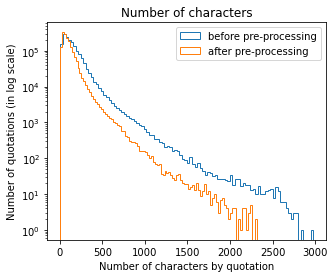

In [26]:
# Same but with log scale for the x-axis
plt.figure(figsize=(5,4))
array0 = plt.hist(analyze.ch_quote, bins=100, log=True, histtype='step')
array1 = plt.hist(analyze.ch_final_quote, bins=100, log=True, histtype='step')
plt.xlabel('Number of characters by quotation')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of characters')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

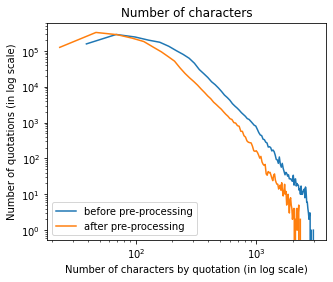

In [27]:
# Same but with log scale for the x-axis and the y-axis
plt.figure(figsize=(5,4))
plt.loglog(array0[1][1:],array0[0])
plt.loglog(array1[1][1:],array1[0])
plt.xlabel('Number of characters by quotation (in log scale)')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of characters')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

The log-log axis confirms that distributions follow power laws.

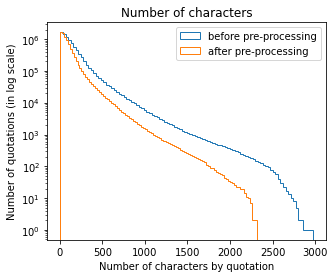

In [28]:
# Same but with log scale for the y-axis and cumulative
plt.figure(figsize=(5,4))
array_cumulative0 = plt.hist(analyze.ch_quote, bins=100, log=True, histtype='step', cumulative=-1)
array_cumulative1 = plt.hist(analyze.ch_final_quote, bins=100, log=True, histtype='step', cumulative=-1)
plt.xlabel('Number of characters by quotation')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of characters')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

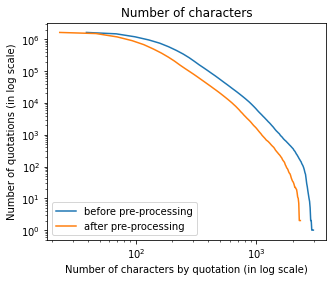

In [29]:
# Same but with log scale for the x-axis and the y-axis and cumulative
plt.figure(figsize=(5,4))
plt.loglog(array_cumulative0[1][1:],array_cumulative0[0])
plt.loglog(array_cumulative1[1][1:],array_cumulative1[0])
plt.xlabel('Number of characters by quotation (in log scale)')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of characters')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

The shift between the two curves confirms that we successfully removed characters between data before processing and data after processing. Some quotations have a very large number of characters (more than 2,000). These outliers will be keept has they can bring robustness to our analysis. However, the quotations with 0 characters will be removed later as they do not provide anything to our analysis.

#### 2.1.2) Analysis about words  <a class="anchor" id="I.2.1.2"></a>

In [30]:
# Creation of a two columns with the number of words per citation before and after NoStopWord (cf. pre-processing)
analyze["wd_quote"] = df["quote_punctfree_token"].apply(lambda x: len(x))
analyze["wd_final_quote"] = df["final_quote"].apply(lambda x: len(x))

analyze.head()

,quoteID,quotation,final_quote,ch_quote,ch_final_quote,ch_removed,wd_quote,wd_final_quote
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,"[How, long, think, itll, take, Donald, Trump, ...",113,77,31.858407,22,13
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,"[And, Im, pointing, absurd, side, Im, sidetaki...",407,291,28.501229,73,52
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...","[And, Michael, Jackson, roller, skating, Donal...",61,47,22.950820,10,7
3,2015-10-20-044420,I like that he's not spinning things. He seems...,"[I, like, he, spinning, thing, He, seems, genu...",148,89,39.864865,29,17
4,2015-12-22-031341,"I promise, I won't talk about Trump again,","[I, promise, I, talk, Trump]",42,22,47.619048,8,5


In [31]:
# Creation of a new column with the percentage of words removed after pre-processing
analyze["wd_removed"] = (analyze["wd_quote"]-analyze["wd_final_quote"])*100/analyze["wd_quote"]

analyze.head()

,quoteID,quotation,final_quote,ch_quote,ch_final_quote,ch_removed,wd_quote,wd_final_quote,wd_removed
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,"[How, long, think, itll, take, Donald, Trump, ...",113,77,31.858407,22,13,40.909091
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,"[And, Im, pointing, absurd, side, Im, sidetaki...",407,291,28.501229,73,52,28.767123
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...","[And, Michael, Jackson, roller, skating, Donal...",61,47,22.950820,10,7,30.000000
3,2015-10-20-044420,I like that he's not spinning things. He seems...,"[I, like, he, spinning, thing, He, seems, genu...",148,89,39.864865,29,17,41.379310
4,2015-12-22-031341,"I promise, I won't talk about Trump again,","[I, promise, I, talk, Trump]",42,22,47.619048,8,5,37.500000


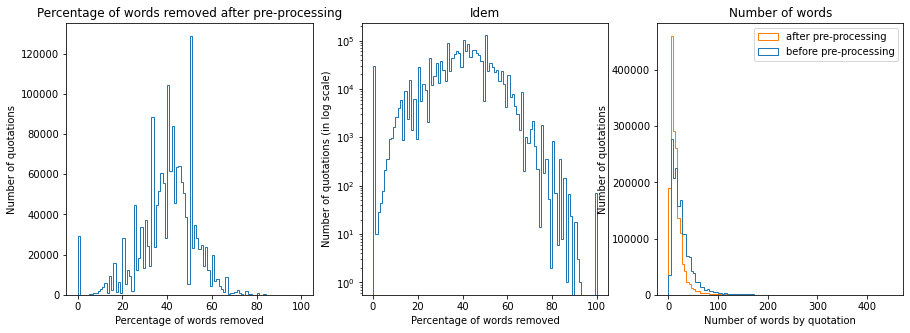

In [32]:
# Plot the distribution of the number of words by quotation before pre-processing data and after pre-processing data
# And plot of the distribution of the percentage of words removed after pre-processing

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].hist(analyze.wd_removed, bins=100, histtype='step')
ax[0].set_title('Percentage of words removed after pre-processing')
ax[0].set_xlabel('Percentage of words removed')
ax[0].set_ylabel('Number of quotations')

ax[1].hist(analyze.wd_removed, bins=100, log=True, histtype='step')
ax[1].set_title('Idem')
ax[1].set_xlabel('Percentage of words removed')
ax[1].set_ylabel('Number of quotations (in log scale)')

ax[2].hist([analyze.wd_quote, analyze.wd_final_quote], bins=100, histtype='step', label=['before pre-processing', 'after pre-processing'])
ax[2].set_title('Number of words')
ax[2].set_xlabel('Number of words by quotation')
ax[2].set_ylabel('Number of quotations')

plt.legend()
plt.show()

In [33]:
#Describe the column about the percentage of characters removed
analyze.wd_removed.describe()

count    1.647515e+06
mean     4.032738e+01
std      1.212191e+01
min      0.000000e+00
25%      3.333333e+01
50%      4.146341e+01
75%      4.821429e+01
max      1.000000e+02
Name: wd_removed, dtype: float64

Again, it seems that the number of words per quotations follow a heavy-tailed distribution, so we will check it later.
The words removed follow a Gaussion distribution centered on around 40%, which is confirmed by the median (41 % of the quotation words removed). The std (12%) shows that the dispersion is quite low.

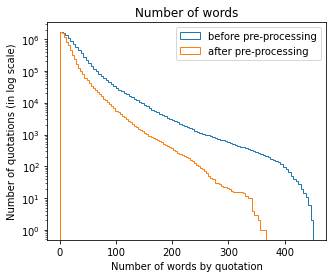

In [34]:
# Same but with log scale for the y-axis and cumulative
plt.figure(figsize=(5,4))
array_cumulative0 = plt.hist(analyze.wd_quote, bins=100, log=True, histtype='step', cumulative=-1)
array_cumulative1 = plt.hist(analyze.wd_final_quote, bins=100, log=True, histtype='step', cumulative=-1)
plt.xlabel('Number of words by quotation')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of words')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

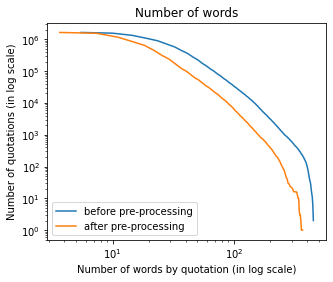

In [35]:
# Same but with log scale for the x-axis and the y-axis and cumulative
plt.figure(figsize=(5,4))
plt.loglog(array_cumulative0[1][1:],array_cumulative0[0])
plt.loglog(array_cumulative1[1][1:],array_cumulative1[0])
plt.xlabel('Number of words by quotation (in log scale)')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of words')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

Once again, the shift between the two curves confirm that words were removed during the pre-processing.

### 2.2) Selection of quotations AND comparison before and after selection  <a class="anchor" id="I.2.2"></a>

In [36]:
# Creation of a new dataframe where we will select only interesting quotations
df_select = df.copy(deep=True)
df_select = df.drop(['quote_punctfree', 'quote_punctfree_token', 'quote_punctfree_token_NoStopWord', 'quote_punctfree_token_NoStopWord_lemm'], 1)
df_select.reset_index(inplace=True)
df_select.head()

C:\Users\felic\AppData\Local\Temp/ipykernel_23684/3449708622.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_select = df.drop(['quote_punctfree', 'quote_punctfree_token', 'quote_punctfree_token_NoStopWord', 'quote_punctfree_token_NoStopWord_lemm'], 1)


,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote
0,0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E,"[How, long, think, itll, take, Donald, Trump, ..."
1,1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,"[And, Im, pointing, absurd, side, Im, sidetaki..."
2,2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,"[And, Michael, Jackson, roller, skating, Donal..."
3,3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E,"[I, like, he, spinning, thing, He, seems, genu..."
4,4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,"[I, promise, I, talk, Trump]"


In [37]:
# Number of quotations before doing the selection
NbIni_quotes = len(df_select)
NbIni_quotes

1647515

In [38]:
# Checking that there is no NA for quotations and speakers
print("{} of NA quotations".format(df_select[df_select.quotation.isnull()].shape[0]))
print("{} of NA speakers".format(df_select[df_select.speaker.isnull()].shape[0]))

0 of NA quotations
0 of NA speakers


#### 2.2.1) Dropping quotations where the main speaker is "None"  <a class="anchor" id="I.2.2.1"></a>

In [39]:
# Dropping rows where the main speaker is "None"
indexNames = df_select[df_select['speaker']=='None'].index
df_select.drop(indexNames, inplace=True)
df_select.head()

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote
0,0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E,"[How, long, think, itll, take, Donald, Trump, ..."
1,1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,"[And, Im, pointing, absurd, side, Im, sidetaki..."
2,2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,"[And, Michael, Jackson, roller, skating, Donal..."
4,4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,"[I, promise, I, talk, Trump]"
6,6,2015-07-21-047379,I'm sure the Republicans are enjoying Mr. Trum...,President Barack Obama,[Q76],2015-07-21 15:18:20,205,"[[President Barack Obama, 0.6523], [None, 0.19...",[http://azdailysun.com/entertainment/televisio...,E,"[Im, sure, Republicans, enjoying, Mr, Trumps, ..."


In [40]:
# Number/Percentage of quotations removed because their main author was "None"
print(f"{NbIni_quotes - len(df_select)} quotations has been removed.")
print(f"{(NbIni_quotes - len(df_select))*100/NbIni_quotes:.0f}% of quotations has been removed.")

391435 quotations has been removed.
24% of quotations has been removed.


#### 2.2.2) Dropping quotations with too weak speaker probability  <a class="anchor" id="I.2.2.2"></a>

Text(0, 0.5, 'Number of quotations')

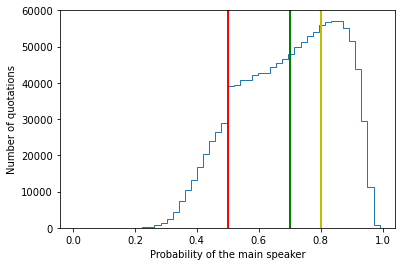

In [41]:
# Distribution of the probability attributed to the main speaker
proba_speaker1 = df_select['probas'].apply(lambda x: x[0][1]).astype(float)
plt.hist(proba_speaker1, bins=50, histtype='step')
plt.axvline(x=0.5, linewidth=2, color='r')
plt.axvline(x=0.7, linewidth=2, color='g')
plt.axvline(x=0.8, linewidth=2, color='y')
plt.xlabel('Probability of the main speaker')
plt.ylabel('Number of quotations')

Each vertical line represents a threshold (0.5, 0.7, 0.8). The aim will be to determined the best threshold to deel with the tradeoff between a good probability for the speaker identity and keeping enough quotations to carry out LDA in the last part.

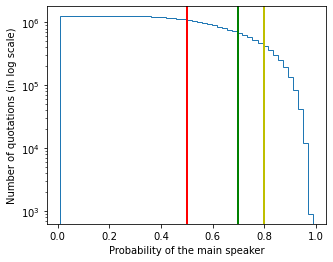

In [42]:
# Same but with log scale for the y-axis and cumulative
plt.figure(figsize=(5,4))
array_cumulative = plt.hist(proba_speaker1, bins=50, log=True, histtype='step', cumulative=-1)
plt.axvline(x=0.5, linewidth=2, color='r')
plt.axvline(x=0.7, linewidth=2, color='g')
plt.axvline(x=0.8, linewidth=2, color='y')
plt.xlabel('Probability of the main speaker')
plt.ylabel('Number of quotations (in log scale)')
plt.show()

In [43]:
# Percentage of quotations removed with the probability p attributed to the main speaker >=0.5 or >=0.7 or >=0.8
print(f"{(len(proba_speaker1[proba_speaker1<0.5]))*100/len(proba_speaker1):.0f}% of quotations would be removed if p>=0.5.")
print(f"{(len(proba_speaker1[proba_speaker1<0.7]))*100/len(proba_speaker1):.0f}% of quotations would be removed if p>=0.7.")
print(f"{(len(proba_speaker1[proba_speaker1<0.8]))*100/len(proba_speaker1):.0f}% of quotations would be removed if p>=0.8.")

# Median probability for the main speaker if if p>=0.5 or p>=0.7 or >=0.8
print(f"p_median = {proba_speaker1[proba_speaker1>0.5].median()} if p>=0.5.")
print(f"p_median = {proba_speaker1[proba_speaker1>0.7].median()} if p>=0.7.")
print(f"p_median = {proba_speaker1[proba_speaker1>0.8].median()} if p>=0.8.")

13% of quotations would be removed if p>=0.5.
47% of quotations would be removed if p>=0.7.
68% of quotations would be removed if p>=0.8.
p_median = 0.7459 if p>=0.5.
p_median = 0.8244 if p>=0.7.
p_median = 0.8696 if p>=0.8.


It seems that removing all the quotations for which the speaker probability is under 0.5 is a good way to deel with the tradeoff: we will know the identity of the speaker with 50% of certitude (in this case, the median probability for the main speaker will be 0.75, which is very good), and theorically we would have enough data to carry the LDA.

In [44]:
# Dropping rows where the probability of the main speaker is < 0.5
indexNames = df_select[df_select['probas'].apply(lambda x: x[0][1]).astype(float)<0.5].index
df_select.drop(indexNames, inplace=True)
df_select.head()

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote
1,1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,"[And, Im, pointing, absurd, side, Im, sidetaki..."
2,2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,"[And, Michael, Jackson, roller, skating, Donal..."
4,4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,"[I, promise, I, talk, Trump]"
6,6,2015-07-21-047379,I'm sure the Republicans are enjoying Mr. Trum...,President Barack Obama,[Q76],2015-07-21 15:18:20,205,"[[President Barack Obama, 0.6523], [None, 0.19...",[http://azdailysun.com/entertainment/televisio...,E,"[Im, sure, Republicans, enjoying, Mr, Trumps, ..."
7,7,2015-07-22-051864,"it in particular thrives on theater, which Tru...",Frank Bruni,[Q1443006],2015-07-22 13:33:11,1,"[[Frank Bruni, 0.8479], [None, 0.1246], [Donal...",[http://www.adweek.com/tvnewser/bob-kerrey-on-...,E,"[particular, thrives, theater, Trump, provides..."


#### 2.2.3) Dropping quotations which do not have a sufficient number of words   <a class="anchor" id="I.2.2.3"></a>

In [122]:
# Creation of a new dataframe analyze_select to analyze the dataframe df_select
analyze_select = df_select.loc[:, ['quoteID', 'quotation', 'final_quote']].copy(deep=True)

# Adding a column with the number of words per quotation
analyze_select["len_quote"] = df_select["final_quote"].apply(lambda x: len(x))

analyze_select.head()

,quoteID,quotation,final_quote,len_quote
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,"[And, Im, pointing, absurd, side, Im, sidetaki...",52
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...","[And, Michael, Jackson, roller, skating, Donal...",7
4,2015-12-22-031341,"I promise, I won't talk about Trump again,","[I, promise, I, talk, Trump]",5
6,2015-07-21-047379,I'm sure the Republicans are enjoying Mr. Trum...,"[Im, sure, Republicans, enjoying, Mr, Trumps, ...",9
7,2015-07-22-051864,"it in particular thrives on theater, which Tru...","[particular, thrives, theater, Trump, provides...",6


Text(0, 0.5, 'Number of quotations')

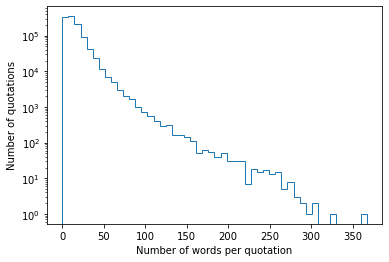

In [123]:
# Distribution of the number of words per quotation
plt.hist(analyze_select["len_quote"], bins=50, histtype='step', log=True)
#plt.axvline(x=0.5, linewidth=2, color='r')
plt.xlabel('Number of words per quotation')
plt.ylabel('Number of quotations')

In [124]:
# Description of the number of words per quotations
analyze_select.len_quote.describe()

count    1.097785e+06
mean     1.480351e+01
std      1.337286e+01
min      0.000000e+00
25%      7.000000e+00
50%      1.100000e+01
75%      1.900000e+01
max      3.670000e+02
Name: len_quote, dtype: float64

Even if most of the quotations have a small number of words (median = 11 words, please note that the median has increased since we remove quotations with no speaker and quotations without words), there are outliers (the maximum is at 367 words). Furthermore, the standard deviation is quite high (~equal to the median value). This phenomenon can be explain by the  heavy-tailed distribution of the data. 
We decided to keep the huge values, as they probably contains important information and bring more precision to our LDA analysis. Nevertheless, if their study reveals that they induce a bias in our conclusions, we will remove them. 

In [125]:
# Number of quotations with 0 words
print(str(analyze_select[analyze_select["len_quote"]==0].shape[0]) + " quotations with 0 words.")

# Dropping quotations with 0 words from analyze
indexNames = analyze_select[analyze_select["len_quote"]==0].index
analyze_select.drop(indexNames, inplace=True)

# Number of quotations with 0 words
print(str(analyze_select[analyze_select["len_quote"]==0].shape[0]) + " quotations with 0 words.")

56 quotations with 0 words.
0 quotations with 0 words.


In [126]:
# Dropping quotations with 0 words from df_select
df_select.drop(indexNames, inplace=True)

In [127]:
# Median of the number of words per quotation
analyze_select["len_quote"].median()

11.0

In [128]:
# % of total lines dropped
print(str(round((df.shape[0] - df_select.shape[0])*100/df.shape[0])) + ".2% of quotations removed.")

# total number of quotations in df_select
print("There is still " + str(df_select.shape[0]) + " quotations in the dataframe.")

# total number of words in df-select
print("There is still " + str(analyze_select.len_quote.sum()) + " words in the dataframe.")

33.2% of quotations removed.
There is still 1097729 quotations in the dataframe.
There is still 16251069 words in the dataframe.


Approximately 30% of the quotations have been removed by the entire selection processus. 

A ENLEVER ??  
Even if around 50,000 quotations are still available for the LDA, this could not be enough. We believe that we would need about 1000 words a week to run the LDA for the duration of D. Trump's campaign and term, which is 5 years (= 260 weeks so 260,000 words and we still have more than twice the required estimated number). Nevertheless, if the LDA can not run, we will have several possibilities to solve the problem: (1) we can increase the threshold about the probability of the speaker identity, (2), we can increase the duration of the time interval to run the LDA (i.e 2 weeks instead of one), or (3), we can do both of the previous solutions.

### 2.3) Filter english text  <a class="anchor" id="I.2.3"></a>

We know that the QuoteBank dataset contains quotations that are not in english. Even though some of these may be related to Donald Trump, we decided to focus on english quotations only. This choice is motivated by the fact that we will apply a topic extraction algorithm based on word frequencies. As most of the quotes will be in english, quotes in other languages will not be properly classified by this approach. We will use the `langdetect` library to detect the language and remove the non-english quotes.

In [129]:
df_select.reset_index(inplace=True)

for index, row in df_select.iterrows():
    try:
        if not langdetect.detect(row["quotation"])=='en' :
            df_select.drop(index, inplace=True)
    except:
        print("error: {} / index: {}".format(row["quotation"], index))

error: 35, 45, 55% / index: 527829
error: ÐÐ 3/4 Ñ ÑÑÐ ¸ ÑÐµÐ ± ÑÐ 3/4 Ð ± Ð ¸ Ð ¶ Ð ° Ð / index: 653431
error: 5... 7... 5... / index: 755160
error: 75%... 50% / index: 772725
error: 10, 20, 40% / index: 864509


We choose to let all these error rows except the one in index 653431 which can be removed.

In [ ]:
df_select.drop(653431, inplace=True)

In [137]:
df_select.reset_index(drop=True, inplace=True)

### 2.4) Final adjustments  <a class="anchor" id="I.2.4"></a>

In [138]:
# Converting the date column into date format
df_select.date = pd.to_datetime(df_select.date)

Text(0, 0.5, 'Number of quotations')

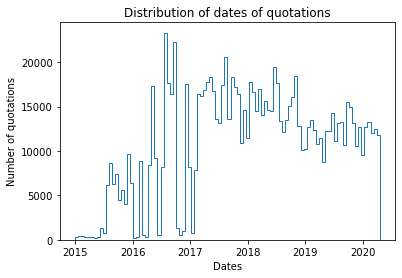

In [139]:
# Plotting the distribution of the dates of quotations
plt.hist(df_select.date, bins=100, histtype='step')
plt.title('Distribution of dates of quotations')
plt.xlabel('Dates')
plt.ylabel('Number of quotations')

In [143]:
# total number of quotations in df_select
print("There is still " + str(df_select.shape[0]) + " quotations in the dataframe.")

There is still 1083091 quotations in the dataframe.


In [140]:
# To convert the pandas DataFrame into pickle
df_select.to_pickle("data/PreProcessData.pkl")

In [141]:
# To load the pickle file into pandas DataFrame
# PreProcess_df = pd.read_pickle("data/PreProcessData.pkl")

In [142]:
# Useless but juste au cas ou
# PreProcessData = df_select.to_csv("data/PreProcessData.csv")

df_select is the final dataframe that we will use to answers our questions. It contains two types of information: the quotations made by D. Trump during its campaign and its term, and the quotations made by other people about D. Trump.

# Part II. Tools for our project about Trump  <a class="anchor" id="PartII"></a>

**_=> QUESTIONS:_**

- **Trump's speech:**
    - 1: What were Donald Trump’s favorite topics to talk about during the campaign (starting in 2015)? and his time in office (20/01/2017 - 20/01/2021)? Is there a change in Trump’s speech/favorite topics between before and after he was elected?
    - (2: How well aligned are Trump’s quotes with its political agenda/program? How close was Donald Trump's presidency from his initial program?)
    - 3: Can we note different periods? Can we correlate changes in the ideas expressed by Trump with external events?  


- **External View about Trump:**
    - 4: Can we quantify Trump popularity over time and correlate it with external events? Can we see the impact of his speech on the population (different groups?)?
    - 5: In which newspapers the quotations of Trump are published? Is there a link between the newspapers that published the most quotations of Trump and the political appartenance of these newspapers?
    - 6: What insight can we get from the difference between quotations from a speaker and quotations about a speaker?

## 1) Data  <a class="anchor" id="II.1"></a>

In [2]:
# To load the pickle file into pandas DataFrame
PreProcess_df = pd.read_pickle("data/PreProcessData.pkl")

In [13]:
# Construction of a dataframe with Trump's quotations
Trump_from = PreProcess_df[PreProcess_df.speaker.str.lower().str.contains("trump")].copy(deep=True)
Trump_from.reset_index(drop=True, inplace=True)
display(Trump_from.shape)
display(Trump_from.head())

(607094, 12)

,level_0,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote
0,919325,0,2015-07-17-029255,I am incredibly pleased that my message is res...,Donald Trump,"[Q22686, Q27947481]",2015-07-17 10:28:58,2,"[[Donald Trump, 0.8415], [None, 0.1356], [Rand...",[http://washingtontimes.com/news/2015/jul/17/d...,E,"[I, incredibly, pleased, message, resonating, ..."
1,919326,1,2015-12-10-038891,I don't want this person representing either t...,Donald Trump,"[Q22686, Q27947481]",2015-12-10 16:20:00,1,"[[Donald Trump, 0.509], [None, 0.491]]",[http://www.westernmorningnews.co.uk/Petition-...,E,"[I, want, person, representing, either, UK, US..."
2,919327,2,2015-11-14-003251,And I will tell you what -- you can say what y...,Donald Trump,"[Q22686, Q27947481]",2015-11-14 22:45:14,6,"[[Donald Trump, 0.798], [None, 0.202]]",[http://news.yahoo.com/paris-wouldve-different...,E,"[And, I, tell, say, want, gun, people, gun, al..."
3,919328,3,2015-10-07-007656,angry at our leaders for not knowing what's ha...,Donald Trump,"[Q22686, Q27947481]",2015-10-07 19:18:48,1,"[[Donald Trump, 0.9064], [None, 0.0936]]",[http://www.radioiowa.com/2015/10/07/trump-rap...,E,"[angry, leader, knowing, whats, happening]"
4,919329,4,2015-09-20-019882,I never called Jeb Bush and I never asked him ...,Donald Trump,"[Q22686, Q27947481]",2015-09-20 14:01:28,2,"[[Donald Trump, 0.5131], [None, 0.459], [Jeb B...",[http://tpmdc.talkingpointsmemo.com/livewire/d...,E,"[I, never, called, Jeb, Bush, I, never, asked,..."


In [3]:
# Construction of a daraframe with quotations about Trump
# (and speaker is not Trump or someone with Trump in his/her name)
Trump_about= PreProcess_df[PreProcess_df.final_quote.apply(lambda x : ' '.join(x)).str.contains("trump")].copy(deep=True)
Trump_about.drop(Trump_about[Trump_about.speaker.str.lower().str.contains("trump")].index, inplace=True)
Trump_about.reset_index(drop=True, inplace=True)
display(Trump_about.shape)
display(Trump_about.head())

(10994, 12)

,level_0,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote
0,20,20,2015-10-31-049808,"really was sort of a trump card for us, for th...",Frances Nunziata,[Q5478874],2015-10-31 00:00:00,1,"[[Frances Nunziata, 0.5726], [None, 0.4274]]",[http://www.thestar.com/news/city_hall/2015/10...,E,"[really, sort, trump, card, u, city, community..."
1,44,44,2015-01-10-028803,No-one's religious convictions can be thought ...,Ronald Dworkin,[Q319803],2015-01-10 11:22:43,1,"[[Ronald Dworkin, 0.8526], [None, 0.1474]]",[http://www.politicsweb.co.za/politicsweb/view...,E,"[Noones, religious, conviction, thought, trump..."
2,50,50,2015-10-02-101163,This experience trumps any kind of internship ...,Don Robinson,"[Q5293421, Q5293423, Q5293424, Q5293425]",2015-10-02 15:05:51,2,"[[Don Robinson, 0.8731], [None, 0.1269]]",[http://web.tampabay.com/news/publicsafety/cle...,E,"[This, experience, trump, kind, internship, an..."
3,76,76,2015-05-21-037157,It's clear the governor is weighing the pros a...,"Steve Morse ,",[Q213952],2015-05-21 19:41:17,1,"[[Steve Morse ,, 0.9493], [None, 0.0394], [Mar...",[http://blogs.mprnews.org/capitol-view/2015/05...,E,"[Its, clear, governor, weighing, pro, con, ris..."
4,79,79,2015-09-19-021975,"I think we have all, all of us recognize that ...",Francis Fonseca,[Q5480967],2015-09-19 04:29:17,1,"[[Francis Fonseca, 0.7981], [None, 0.2019]]",[http://edition.channel5belize.com/archives/11...,E,"[I, think, u, recognize, party, u, come, toget..."


## 2) LDA function  <a class="anchor" id="II.2"></a>

To extract topics from Trump's speech, which is needed to answer several of our questions, we will use a topic model. We chose to start with Latent Dirichlet Allocation (LDA), as it is quite straighforward and we have had successful results with it in the past. If our results with LDA are not satisfactory, we will try with [Octis](https://github.com/MIND-Lab/OCTIS), which is used to compare several topic models.

LDA is a generative statistical model which models each document (in our case temporal chunks of quotes by Trump) as a mixture of a number of topics. A topic (in our case, we expect to find subjects such as 'economics', 'ecology', etc.) is itself modeled as a mixture of words. This will thus allow us to extract a certain number of topics from Trump's speech and to see how these topics are represented in each document. Of particular interest to us for configuring our topic extraction are three hyperparameters: alpha (which controls how many topics make up each document), beta (which controls how many words make up each topic) and the number of topics. For more mathematical details, the [wikipedia page for LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is quite informative.

To check the feasability of LDA in terms of running time and effectiveness, we have implemented a prototype named `timechunk_lda` below. This function aggregates quotations into range of dates of a given size and applies LDA on these aggregated documents. As this was just to test things out, we have not optimized the hyperparameters yet, but we can already see that topics are being extracted quite well.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import math
import numpy as np

def make_timechunks(chunksize, min_dt, max_dt):
    '''make timechunks of size chunksize starting at min_dt and ending at max_dt'''
    delta = pd.Timedelta(chunksize)
    num_iters = math.ceil((max_dt-min_dt)/delta)
    a = min_dt
    b = min_dt
    timechunks = []
    for _ in range(num_iters):
        b = a+delta
        timechunks.append([a, b])
        a = b 
    return timechunks

def get_words_and_weights(lda, feature_names, n_top):
    '''get_words_and_weights: retrieve topic words and their weights for each topic'''
    topic_ids = []
    topic_words = []
    words_weights = []
    for topic_id, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[: -n_top - 1 : -1]
        top_words = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        topic_ids.append(topic_id)
        topic_words.append(top_words)
        words_weights.append(weights)
    return topic_ids, topic_words, words_weights

def timechunk_lda(df, text_col, dt_col, chunksize, n_components, n_top=10, 
                  max_iter=15, random_state=2, max_df=0.95, min_df=1, 
                  max_features=1000):
    '''timechunk_lda: Aggregate quotes into date ranges of size chunksize and perform
                      latent dirichlet allocation to extract topic
    Inputs:
    -------
    - df: input dataframe
    - text_col: column containing text (either as strings or list of strings) in df
    - dt_col: column containing Timestamps in df
    - chunksize: size of chunks in days, e.g. '10D' == 10 days
    - n_components: number of different topics to model
    - n_top: number of top words to consider when summarizing a topic
    - max_iter: maximum number of iteration for online lda
    - random_state: lda random state
    - max_df: When building the vocabulary ignore terms that have a document frequency 
              strictly higher than the given threshold (corpus-specific stop words). 
              If float, the parameter represents a proportion of documents, integer 
              absolute counts. This parameter is ignored if vocabulary is not None.
    - min_df: When building the vocabulary ignore terms that have a document frequency 
              strictly lower than the given threshold. This value is also called cut-off 
              in the literature. If float, the parameter represents a proportion of 
              documents, integer absolute counts. This parameter is ignored if vocabulary 
              is not None.
    - max_features: vocabulary size
    
    Outputs:
    --------
    - df: input df with two additional columns, `topic_id_{chunksize}` the assigned topic
          and `topics_dist_{chunksize}` the topic assignment distribution.
    - topics_df: topics dataframe, contains topic_id, words and normalized word weight
                 for each topic.
    - timechunks_df: timechunks dataframe, contains start date (included) and end date 
                     (excluded) of each chunk.'''
    # Transform text column to string if passed as list of strings
    created_text_col = False
    if type(df[text_col].to_list()[0]) == list:
        df['str_text_col'] = df[text_col].apply(lambda x: ' '.join(x))
        text_col = 'str_text_col'
        created_text_col = True
    # Create vectorizer and lda objects
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, 
                                 max_features=max_features, 
                                 stop_words="english")
    lda = LatentDirichletAllocation(n_components=n_components,
                                    max_iter=max_iter,
                                    learning_method="online",
                                    random_state=random_state)
    # Aggregate documents according to passed chunksize
    documents = []
    documents_lengths = []
    timechunks = make_timechunks(chunksize, df[dt_col].min(), df[dt_col].max())
    for chunk in timechunks:
        document_list = df[
            df[dt_col].between(chunk[0], chunk[1], inclusive='left')
        ][text_col].to_list()
        documents.append(' '.join(document_list))
        documents_lengths.append(len(document_list))
    # Vectorize data
    tokens = vectorizer.fit_transform(documents)
    # Compute topic distribution for each document and assigned topic (argmax)
    assigned_topics = lda.fit_transform(tokens)
    topics_dist_column = []
    topics_column = []
    total_length = 0
    for document_length, assigned_topic in zip(documents_lengths, assigned_topics):
        total_length += document_length
        topics_dist_column.extend(document_length*[list(assigned_topic)])
        topics_column.extend(document_length*[assigned_topic.argmax()])
    # Add to dataframe
    df[f'topic_id_{chunksize}'] = topics_column
    df[f'topics_dist_{chunksize}'] = topics_dist_column
    # Retrieve topic words and associated words
    topic_ids, topic_words, words_weights = get_words_and_weights(
        lda, vectorizer.get_feature_names(), n_top
    )
    # Create topic dataframe with topic_id, chunksize, [word, normalized_weight]
    # normalized weight computed with normalized exponential (softmax) of word weight
    # for each topic
    colnames = ['topic_id', 'chunksize']
    for i in range(1, n_top+1):
        colnames.append(f'topic_word_{i}')
        colnames.append(f'normalized_weight_{i}')
    topics_df = pd.DataFrame(columns=colnames)
    for topic_id, words, weights in zip(topic_ids, topic_words, words_weights):
        tmp = [topic_id, chunksize]
        denom = np.exp(np.array(weights)).sum()
        for word, weight in zip(words, weights):
            normalized_weight = np.exp(weight)/denom
            tmp.extend([word, normalized_weight])
        topics_df.loc[len(topics_df.index)] = tmp
    # Make timechunks_df
    timechunks_df = pd.DataFrame(columns=['start_date', 'end_date'])
    timechunks_df['start_date'] = [chunk[0] for chunk in timechunks]
    timechunks_df['end_date'] = [chunk[1] for chunk in timechunks]
    # Delete additional text column if added
    if created_text_col:
        df.drop(columns=['str_text_col'], inplace=True)
    return df, topics_df, timechunks_df

In [ ]:
chunksize = '14D'
df_select_with_topics, topics_df, timechunks_df = timechunk_lda(
    df_select, 'final_quote_SelectWd', 'date', chunksize, 3, 5
)
np.unique(df_select_with_topics[f'topic_id_{chunksize}'].values)

/tmp/ipykernel_22627/1556851603.py:119: RuntimeWarning: overflow encountered in exp
  denom = np.exp(np.array(weights)).sum()
/tmp/ipykernel_22627/1556851603.py:121: RuntimeWarning: overflow encountered in exp
  normalized_weight = np.exp(weight)/denom
/tmp/ipykernel_22627/1556851603.py:121: RuntimeWarning: invalid value encountered in double_scalars
  normalized_weight = np.exp(weight)/denom


array([0, 1, 2])

We notice that we have some overflows on the weights. This is a minor bug which will be fixed in milestone 3.

In [ ]:
topics_df

,topic_id,chunksize,topic_word_1,normalized_weight_1,topic_word_2,normalized_weight_2,topic_word_3,normalized_weight_3,topic_word_4,normalized_weight_4,topic_word_5,normalized_weight_5
0,0,14D,bloomberg,0.92242,coronavirus,7.758027e-02,modi,8.356168e-27,stone,1.626502e-68,billionaire,1.462992e-72
1,1,14D,soleimani,1.00000,witness,1.276672e-23,peace,3.945621e-26,iraq,1.104616e-30,terrorist,7.395535e-42
2,2,14D,coronavirus,NaN,virus,0.000000e+00,pandemic,0.000000e+00,ventilator,0.000000e+00,covid19,0.000000e+00


In [ ]:
timechunks_df

,start_date,end_date
0,2020-01-01,2020-01-15
1,2020-01-15,2020-01-29
2,2020-01-29,2020-02-12
3,2020-02-12,2020-02-26
4,2020-02-26,2020-03-11
5,2020-03-11,2020-03-25
6,2020-03-25,2020-04-08
7,2020-04-08,2020-04-22


## 3) Sentiment analysis  <a class="anchor" id="II.3"></a>

To analyze quotations about Trump, we will use a pre-trained sentiment analysis model, such as [Flair](https://github.com/flairNLP/flair). Such a model would allow us to classify quotations between positive and negative. We chose to start with Flair because it is pre-trained so we believe it will be easier to get started with. It can also take negations and intensifiers into account, and can work for never seen before and misspelt words. When doing sentiment analysis, we will use the original quotations because word order and stopwords can be important here.

### 3.1) Flair  <a class="anchor" id="II.3.1"></a>

In [4]:
# Flair function for sentiment analysis
def flair_analysis(quotation):
    classifier = flair.models.TextClassifier.load('en-sentiment')
    sentence = flair.data.Sentence(quotation)
    classifier.predict(sentence)
    value = sentence.labels[0].to_dict()['value']
    confidence = sentence.labels[0].to_dict()['confidence']
    return [value, confidence]

In [ ]:
# Sections of dataframe to run progressively in case of error after a while
size = 1000
df_list = [Trump_about[pos:pos+size] for pos in range(0, len(Trump_about), size)]

# Flair sentiment analysis
for n, df_seq in enumerate(df_list):
    df_out = df_seq.copy()
    df_out.loc[:,"Flair"] = df_out.quotation.apply(flair_analysis)
    df_list[n] = df_out
    print("df_list: {} / index_Trump_about: {}". format(n, df_out.index))

In [ ]:
# Constructing the new dataframe with Flair sentiment analysis
Trump_about_flair = pd.concat(df_list, ignore_index=True)
Trump_about_flair = pd.concat([Trump_about_flair,pd.DataFrame(Trump_about_flair['Flair'].tolist(), columns=['FlairSentiment', 'FlairConfidence'])], axis=1)

Trump_about_flair

In [18]:
Trump_about_flair.reset_index(drop=True, inplace=True)

# Saving dataframe
Trump_about_flair.to_pickle("data/Trump_about_flair.pkl")

In [6]:
# Loading the pickle file into pandas DataFrame
Trump_about_flair = pd.read_pickle("data/Trump_about_flair.pkl")

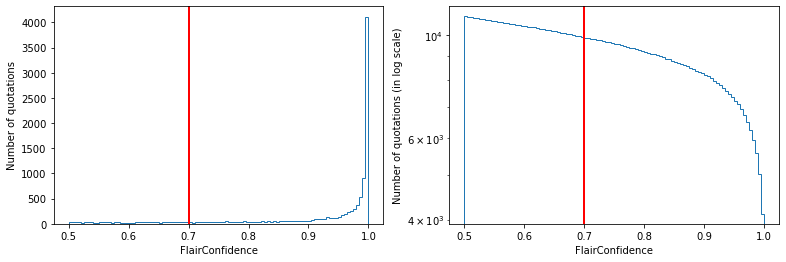

In [8]:
fig, ax = plt.subplots(1,2,figsize=(13,4))

# Visualizing FlairConfidence
ax[0].hist(Trump_about_flair.FlairConfidence, bins=100, histtype='step')
ax[0].axvline(x=0.7, linewidth=2, color='r')
ax[0].set_xlabel('FlairConfidence')
ax[0].set_ylabel('Number of quotations')

# Same but with log scale for the y-axis and cumulative
array_cumulative = ax[1].hist(Trump_about_flair.FlairConfidence, bins=100, log=True, histtype='step', cumulative=-1)
ax[1].axvline(x=0.7, linewidth=2, color='r')
ax[1].set_xlabel('FlairConfidence')
ax[1].set_ylabel('Number of quotations (in log scale)')

plt.show()

In [9]:
# Removing row with FlairConfidence < 0.7
NbIni_quotes = len(Trump_about_flair)
indexNames = Trump_about_flair[Trump_about_flair.FlairConfidence.apply(lambda x: x<0.7)].index
Trump_about_flair.drop(indexNames, inplace=True)
Trump_about_flair.reset_index(drop=True, inplace=True)

print(f"{NbIni_quotes - len(Trump_about_flair)} quotations has been removed.")
print(f"{(NbIni_quotes - len(Trump_about_flair))*100/NbIni_quotes:.0f}% of quotations has been removed.")

1110 quotations has been removed.
10% of quotations has been removed.


Text(0, 0.5, 'Number of quotations')

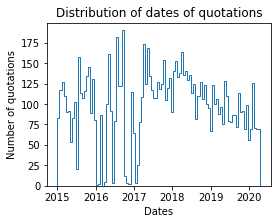

In [10]:
# Plotting the distribution of the dates of quotations
figure = plt.figure(figsize=(4,3))
plt.hist(Trump_about_flair.date, bins=100, histtype='step')
plt.title('Distribution of dates of quotations')
plt.xlabel('Dates')
plt.ylabel('Number of quotations')

### 3.2) VaderSentiment  <a class="anchor" id="II.3.2"></a>

We will use a second pre-trained sentiment analysis model as "verification". For this, we will use VADER ( Valence Aware Dictionary for Sentiment Reasoning) which is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion.

In [11]:
# Sections of dataframe to run progressively in case of error after a while
size = 1000
df_list = [Trump_about_flair[pos:pos+size] for pos in range(0, len(Trump_about_flair), size)]

# Analyser
analyzer = SentimentIntensityAnalyzer()

# Vader sentiment analysis
for n, df_seq in enumerate(df_list):
    df_out = df_seq.copy()
    df_out.loc[:,"Vader"] = df_out.quotation.apply(lambda x: analyzer.polarity_scores(x))
    df_list[n] = df_out
    print("df_list: {} / index_Trump_about_flair: {}". format(n, df_out.index))

df_list: 0 / index_Trump_about_flair: RangeIndex(start=0, stop=1000, step=1)
df_list: 1 / index_Trump_about_flair: RangeIndex(start=1000, stop=2000, step=1)
df_list: 2 / index_Trump_about_flair: RangeIndex(start=2000, stop=3000, step=1)
df_list: 3 / index_Trump_about_flair: RangeIndex(start=3000, stop=4000, step=1)
df_list: 4 / index_Trump_about_flair: RangeIndex(start=4000, stop=5000, step=1)
df_list: 5 / index_Trump_about_flair: RangeIndex(start=5000, stop=6000, step=1)
df_list: 6 / index_Trump_about_flair: RangeIndex(start=6000, stop=7000, step=1)
df_list: 7 / index_Trump_about_flair: RangeIndex(start=7000, stop=8000, step=1)
df_list: 8 / index_Trump_about_flair: RangeIndex(start=8000, stop=9000, step=1)
df_list: 9 / index_Trump_about_flair: RangeIndex(start=9000, stop=9884, step=1)


In [12]:
# Adding Vader sentiment analysis in a new dataframe
Trump_about_sentiment = pd.concat(df_list, ignore_index=True)

# Column with Vader compound
Trump_about_sentiment['VaderCompound']  = Trump_about_sentiment.Vader.apply(lambda x: x['compound'])

# Column with final Vader sentiment
Trump_about_sentiment['VaderSentiment'] = Trump_about_sentiment.VaderCompound.apply(lambda x: 'POSITIVE' if x >=0 else 'NEGATIVE')

Trump_about_sentiment

,level_0,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote,Flair,FlairSentiment,FlairConfidence,Vader,VaderCompound,VaderSentiment
0,20,20,2015-10-31-049808,"really was sort of a trump card for us, for th...",Frances Nunziata,[Q5478874],2015-10-31 00:00:00,1,"[[Frances Nunziata, 0.5726], [None, 0.4274]]",[http://www.thestar.com/news/city_hall/2015/10...,E,"[really, sort, trump, card, u, city, community...","[NEGATIVE, 0.809940755367279]",NEGATIVE,0.809941,"{'neg': 0.0, 'neu': 0.963, 'pos': 0.037, 'comp...",0.0772,POSITIVE
1,44,44,2015-01-10-028803,No-one's religious convictions can be thought ...,Ronald Dworkin,[Q319803],2015-01-10 11:22:43,1,"[[Ronald Dworkin, 0.8526], [None, 0.1474]]",[http://www.politicsweb.co.za/politicsweb/view...,E,"[Noones, religious, conviction, thought, trump...","[POSITIVE, 0.9058087468147278]",POSITIVE,0.905809,"{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'comp...",0.6369,POSITIVE
2,50,50,2015-10-02-101163,This experience trumps any kind of internship ...,Don Robinson,"[Q5293421, Q5293423, Q5293424, Q5293425]",2015-10-02 15:05:51,2,"[[Don Robinson, 0.8731], [None, 0.1269]]",[http://web.tampabay.com/news/publicsafety/cle...,E,"[This, experience, trump, kind, internship, an...","[POSITIVE, 0.8494822382926941]",POSITIVE,0.849482,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,POSITIVE
3,76,76,2015-05-21-037157,It's clear the governor is weighing the pros a...,"Steve Morse ,",[Q213952],2015-05-21 19:41:17,1,"[[Steve Morse ,, 0.9493], [None, 0.0394], [Mar...",[http://blogs.mprnews.org/capitol-view/2015/05...,E,"[Its, clear, governor, weighing, pro, con, ris...","[POSITIVE, 0.9475823044776917]",POSITIVE,0.947582,"{'neg': 0.059, 'neu': 0.803, 'pos': 0.138, 'co...",0.2617,POSITIVE
4,79,79,2015-09-19-021975,"I think we have all, all of us recognize that ...",Francis Fonseca,[Q5480967],2015-09-19 04:29:17,1,"[[Francis Fonseca, 0.7981], [None, 0.2019]]",[http://edition.channel5belize.com/archives/11...,E,"[I, think, u, recognize, party, u, come, toget...","[POSITIVE, 0.9893627762794495]",POSITIVE,0.989363,"{'neg': 0.0, 'neu': 0.765, 'pos': 0.235, 'comp...",0.9724,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9879,918842,918842,2020-02-10-060896,`Parasite' has dealt a much-needed slap to the...,Justin Chang,[Q30687995],2020-02-10 00:00:00,2,"[[Justin Chang, 0.9267], [None, 0.0684], [Bong...",[https://www.forbes.com/sites/isabeltogoh/2020...,E,"[Parasite, dealt, muchneeded, slap, American, ...","[POSITIVE, 0.9994520545005798]",POSITIVE,0.999452,"{'neg': 0.112, 'neu': 0.81, 'pos': 0.078, 'com...",-0.1280,NEGATIVE
9880,918886,918886,2020-01-29-128159,You'd do something crazy! I feel like Calum wo...,Michael Clifford,"[Q21282968, Q57890779]",2020-01-29 02:14:27,1,"[[Michael Clifford, 0.7178], [Calum Hood, 0.16...",[https://www.j-14.com/posts/5-seconds-of-summe...,E,"[Youd, something, crazy, I, feel, like, Calum,...","[NEGATIVE, 0.9040436148643494]",NEGATIVE,0.904044,"{'neg': 0.114, 'neu': 0.667, 'pos': 0.219, 'co...",0.2942,POSITIVE
9881,918902,918902,2020-01-24-066679,public safety should be the priority; it shoul...,Enrique Fernandez,"[Q1343998, Q52017342]",2020-01-24 22:57:49,1,"[[Enrique Fernandez, 0.9237], [None, 0.0763]]",[https://www.dailydemocrat.com/2020/01/24/wood...,E,"[public, safety, priority, trump, pool]","[NEGATIVE, 0.9134876132011414]",NEGATIVE,0.913488,"{'neg': 0.0, 'neu': 0.781, 'pos': 0.219, 'comp...",0.4215,POSITIVE
9882,918916,918916,2020-01-07-004548,And Mr Stoller has come up trumps again so tha...,Peter Davis,"[Q21463617, Q3376528, Q7173569, Q7173570, Q717...",2020-01-07 15:44:38,2,"[[Peter Davis, 0.8406], [Matthew Taylor, 0.096...",[http://www.oldham-chronicle.co.uk/news-featur...,E,"[And, Mr, Stoller, come, trump, thank, much]","[POSITIVE, 0.9717126488685608]",POSITIVE,0.971713,"{'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'comp...",0.5009,POSITIVE


In [13]:
# Saving dataframe
Trump_about_sentiment.to_pickle("data/Trump_about_sentiment.pkl")

In [2]:
# Loading the pickle file into pandas DataFrame
Trump_about_sentiment = pd.read_pickle("data/Trump_about_sentiment.pkl")

In [15]:
# Comparaison between Flair and Vader
Trump_about_sentiment['SentimentIsEqual'] = (Trump_about_sentiment.FlairSentiment==Trump_about_sentiment.VaderSentiment)

print("SentimentIsEqual:\n{}".format(Trump_about_sentiment.SentimentIsEqual.value_counts()))
print("........")
print("FlairSentiment: \n{}".format(Trump_about_sentiment.FlairSentiment.value_counts()))
print("........")
print("VaderSentiment: \n{}".format(Trump_about_sentiment.VaderSentiment.value_counts()))
print("........")

SentimentIsEqual:
True     6260
False    3624
Name: SentimentIsEqual, dtype: int64
........
FlairSentiment: 
NEGATIVE    5346
POSITIVE    4538
Name: FlairSentiment, dtype: int64
........
VaderSentiment: 
POSITIVE    7156
NEGATIVE    2728
Name: VaderSentiment, dtype: int64
........


## 4) Additional data  <a class="anchor" id="II.4"></a>

### Approval ratings

To be able to better interpret the fluctuations of the sentiments in the quotes about Trump, we chose to use some additional approval rating data. The data comes from https://projects.fivethirtyeight.com/trump-approval-ratings/. We chose this data source for the following reasons: 
- it aggregates the results of several polls, so it should be more representative
- it includes error bars, so we will be able to see if our interpretations are statistically significant

Below we load the data into a dataframe and plot it as a line.

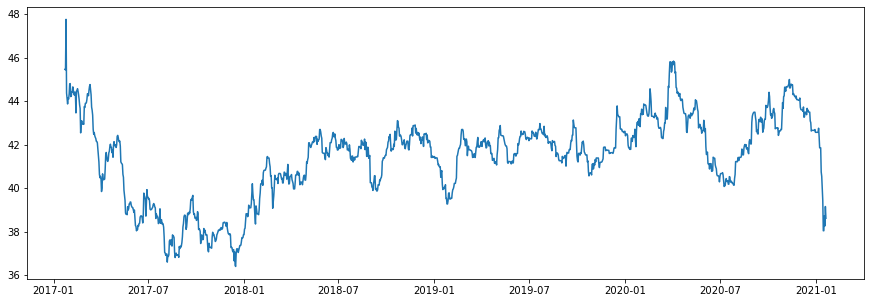

In [ ]:
df_approval = pd.read_csv("data/approval_topline.csv")
df_approval = df_approval[df_approval.subgroup == "All polls"][["modeldate", "approve_estimate"]].iloc[::-1].reset_index(drop=True)
df_approval["modeldate"] = pd.to_datetime(df_approval["modeldate"])
from matplotlib.pyplot import figure
figure(figsize=(15, 5))
plt.plot(df_approval["modeldate"], df_approval["approve_estimate"])

### Speakers metadata

In [ ]:
import numpy as np

# Get metadata of speaker that appear in our final selection
unique_qids = list(np.unique(
    np.array(df_select.qids.apply(lambda x: x[0] if len(x) > 0 else None))
))
print(f'Number of unique QIDs in our filtered dataset: {len(unique_qids)}')
metadata_df = pd.read_parquet('data/speaker_attributes.parquet')
print(f'Initial number of speakers in metadata: {metadata_df.shape[0]}')
metadata_df = metadata_df.loc[metadata_df.id.isin(unique_qids)]
print(f'Number of speakers in our dataset and in the metadata: {metadata_df.shape[0]}')

Number of unique QIDs in our filtered dataset: 5268
Initial number of speakers in metadata: 9055981
Number of speakers in our dataset and in the metadata: 5221


# Part III. Our project about Trump  <a class="anchor" id="PartIII"></a>

## Question 4: Can we quantify Trump popularity over time and correlate it with external events? Can we see the impact of his speech on the population (different groups of population?)?   <a class="anchor" id="III.4"></a>

### 4.1) Trump popularity over time   <a class="anchor" id="III.4.1"></a>

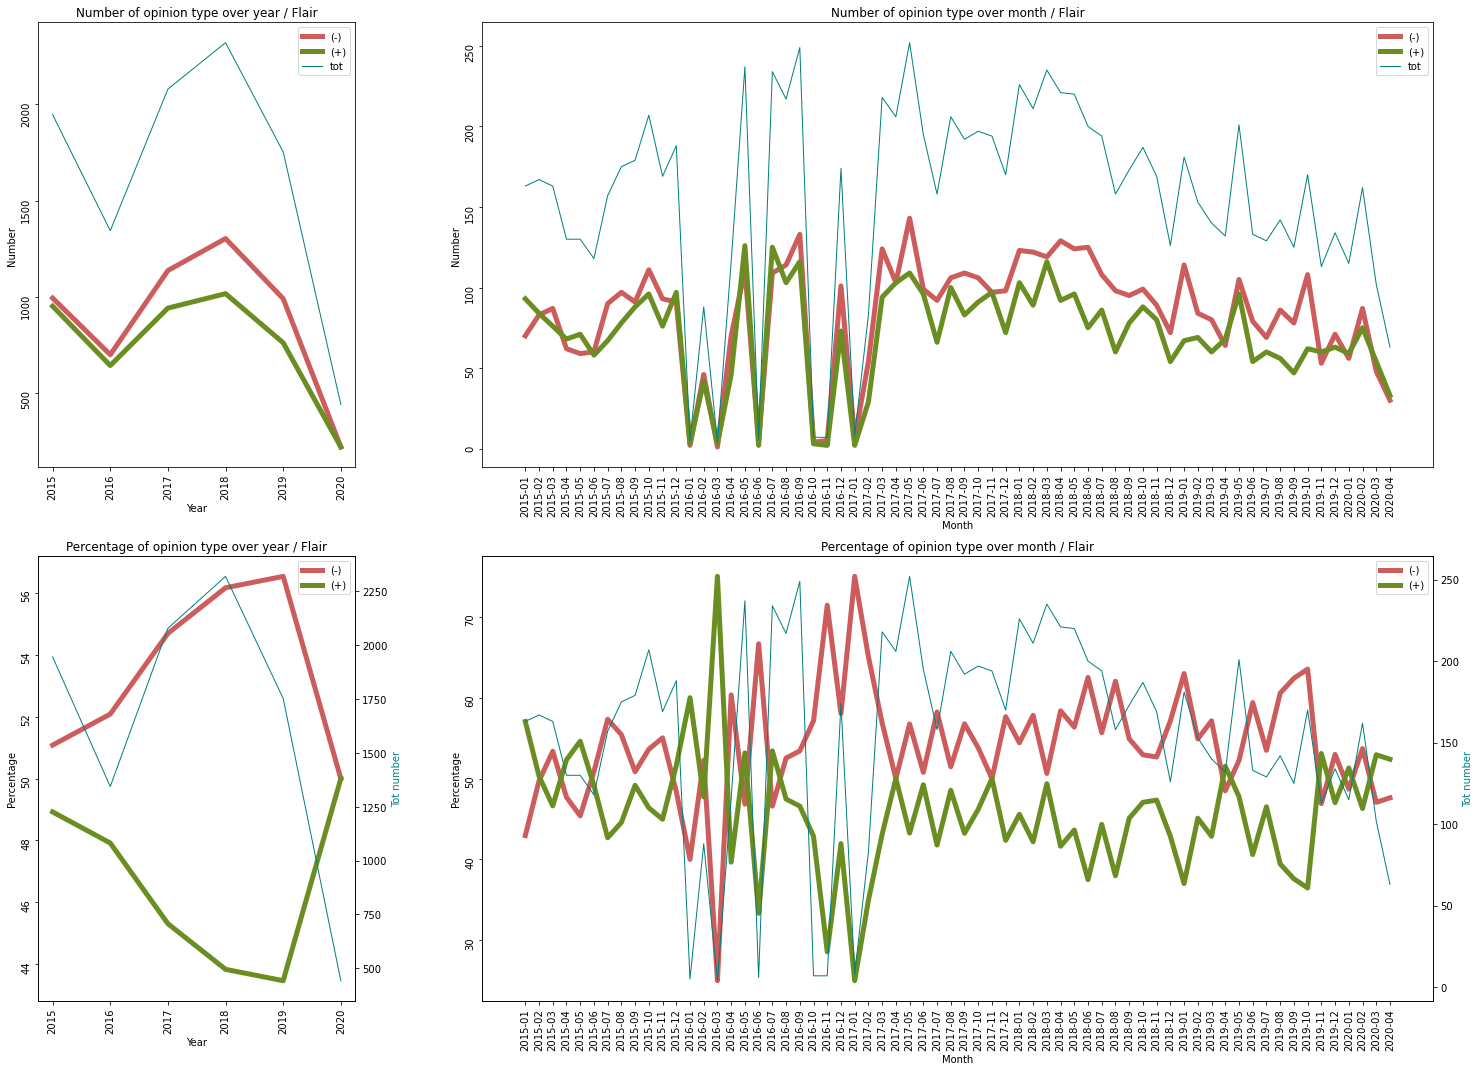

In [112]:
# Stats for Flair:

## Calculate yearly stats about sentiments
stats_year_Flair = Trump_about_sentiment.groupby(Trump_about_sentiment['date'].map(lambda x: x.year)) \
                .apply(lambda x: pd.Series({
                     'number_negative': x['FlairSentiment'].value_counts()['NEGATIVE'],
                     'number_positive': x['FlairSentiment'].value_counts()['POSITIVE'],
                     'number_tot': len(x['FlairSentiment']),
                     'percent_negative': x['FlairSentiment'].value_counts()['NEGATIVE']*100/len(x['FlairSentiment']),
                     'percent_positive': x['FlairSentiment'].value_counts()['POSITIVE']*100/len(x['FlairSentiment'])
    }))

## Calculate monthly stats about sentiments
stats_month_Flair = Trump_about_sentiment.groupby([Trump_about_sentiment.date.dt.year, Trump_about_sentiment.date.dt.month]) \
                .apply(lambda x: pd.Series({
                     'number_negative': x['FlairSentiment'].value_counts()['NEGATIVE'],
                     'number_positive': x['FlairSentiment'].value_counts()['POSITIVE'],
                     'number_tot': len(x['FlairSentiment']),
                     'percent_negative': x['FlairSentiment'].value_counts()['NEGATIVE']*100/len(x['FlairSentiment']),
                     'percent_positive': x['FlairSentiment'].value_counts()['POSITIVE']*100/len(x['FlairSentiment'])
    }))


# Graphs for Flair:

fig, ax = plt.subplots(2,2,figsize=(25,18), gridspec_kw={'width_ratios': [1, 3]})

## Graphs by year
ax[0,0].plot(stats_year_Flair.index, stats_year_Flair.number_negative, label='(-)', color='indianred', linewidth=5.0)
ax[0,0].plot(stats_year_Flair.index, stats_year_Flair.number_positive, label='(+)', color='olivedrab', linewidth=5.0)
ax[0,0].plot(stats_year_Flair.index, stats_year_Flair.number_tot, label='tot', color='teal', linewidth=1.0)
ax[0,0].set_title('Number of opinion type over year / Flair')
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Number')
ax[0,0].tick_params(labelrotation=90)
ax[0,0].legend()

ax[1,0].plot(stats_year_Flair.index, stats_year_Flair.percent_negative, label='(-)', color='indianred', linewidth=5.0)
ax[1,0].plot(stats_year_Flair.index, stats_year_Flair.percent_positive, label='(+)', color='olivedrab', linewidth=5.0)
ax101 = ax[1,0].twinx()
ax101.plot(stats_year_Flair.index, stats_year_Flair.number_tot, color='teal', linewidth=1.0)
ax[1,0].set_title('Percentage of opinion type over year / Flair')
ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Percentage')
ax101.set_ylabel('Tot number', color='teal')
ax[1,0].tick_params(labelrotation=90)
ax[1,0].legend()

## Graphs by month
x_month_Flair = pd.to_datetime(stats_month_Flair.index.to_series().apply(lambda x: str(x[0])+"-"+str(x[1]))) \
.dt.date.apply(lambda x: x.strftime('%Y-%m'))

ax[0,1].plot(x_month_Flair, stats_month_Flair.number_negative, label='(-)', color='indianred', linewidth=5.0)
ax[0,1].plot(x_month_Flair, stats_month_Flair.number_positive, label='(+)', color='olivedrab', linewidth=5.0)
ax[0,1].plot(x_month_Flair, stats_month_Flair.number_tot, label='tot', color='teal', linewidth=1.0)
ax[0,1].set_title('Number of opinion type over month / Flair')
ax[0,1].set_xlabel('Month')
ax[0,1].set_ylabel('Number')
ax[0,1].tick_params(labelrotation=90)
ax[0,1].legend()

ax[1,1].plot(x_month_Flair, stats_month_Flair.percent_negative, label='(-)', color='indianred', linewidth=5.0)
ax[1,1].plot(x_month_Flair, stats_month_Flair.percent_positive, label='(+)', color='olivedrab', linewidth=5.0)
ax111 = ax[1,1].twinx()
ax111.plot(x_month_Flair, stats_month_Flair.number_tot, color='teal', linewidth=1.0)
ax[1,1].set_title('Percentage of opinion type over month / Flair')
ax[1,1].set_xlabel('Month')
ax[1,1].set_ylabel('Percentage')
ax111.set_ylabel('Tot number', color='teal')
ax[1,1].tick_params(labelrotation=90)
ax[1,1].legend()

plt.show()

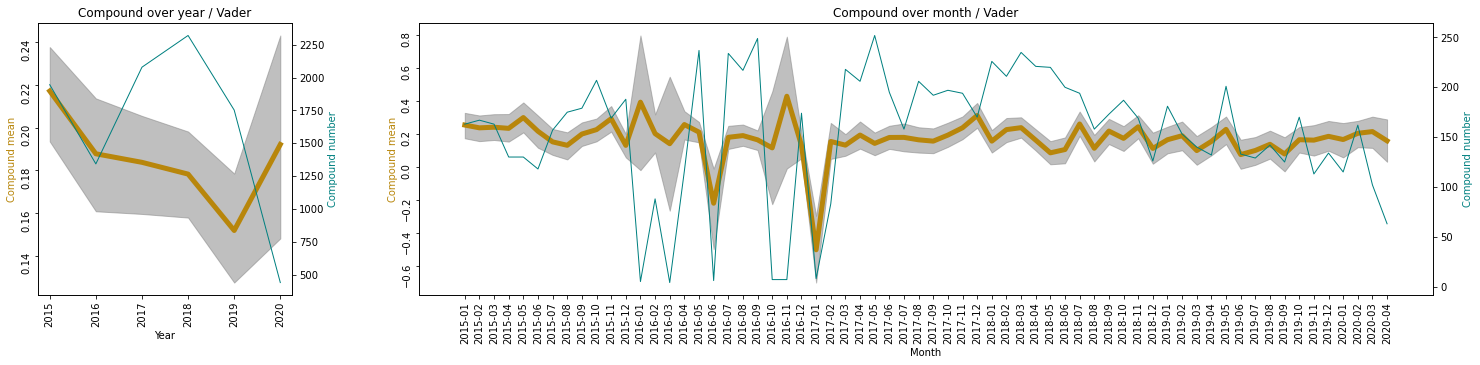

In [113]:
# Comparison with VaderCompound:

## Bootstrapping function to obtain 95% confidence intervals around the estimated average. 
    # Input: your array and the number of random samples (e.g., 1000 is a good number)
    # Output: [lower error, upper error]
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)
    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]


## Stats

### Calculate yearly stats about sentiments
stats_year_Vader = Trump_about_sentiment.groupby(Trump_about_sentiment['date'].map(lambda x: x.year)) \
                    .apply(lambda x: pd.Series({
                            'average_VaderCompound': x['VaderCompound'].mean(),
                            'lower_err_VaderCompound': bootstrap_CI(x['VaderCompound'], 1000)[0],
                            'upper_err_VaderCompound': bootstrap_CI(x['VaderCompound'], 1000)[1],
                            'number_VaderCompound': len(x['VaderCompound']),
    }))

### Calculate monthly stats about sentiments
stats_month_Vader = Trump_about_sentiment.groupby([Trump_about_sentiment.date.dt.year, Trump_about_sentiment.date.dt.month]) \
                    .apply(lambda x: pd.Series({
                            'average_VaderCompound': x['VaderCompound'].mean(),
                            'lower_err_VaderCompound': bootstrap_CI(x['VaderCompound'], 1000)[0],
                            'upper_err_VaderCompound': bootstrap_CI(x['VaderCompound'], 1000)[1],
                            'number_VaderCompound': len(x['VaderCompound']),
    }))


## Graphs

fig, ax = plt.subplots(1,2,figsize=(25,5), gridspec_kw={'width_ratios': [1, 4]})

### Graphs by year
ax[0].fill_between(stats_year_Vader.index, 
                    stats_year_Vader.lower_err_VaderCompound,
                    stats_year_Vader.upper_err_VaderCompound, alpha=0.5, color='gray')
ax[0].plot(stats_year_Vader.index, stats_year_Vader.average_VaderCompound, color='darkgoldenrod', label='mean', linewidth=5.0)
ax01 = ax[0].twinx()
ax01.plot(stats_year_Vader.index, stats_year_Vader.number_VaderCompound, color="teal", label='number', linewidth=1.0)
ax[0].set_title('Compound over year / Vader')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Compound mean', color="darkgoldenrod")
ax01.set_ylabel('Compound number', color="teal")
ax[0].tick_params(labelrotation=90)

### Graphs by month
x_month_Vader = pd.to_datetime(stats_month_Flair.index.to_series().apply(lambda x: str(x[0])+"-"+str(x[1]))) \
.dt.date.apply(lambda x: x.strftime('%Y-%m'))

ax[1].fill_between(x_month_Vader, 
                    stats_month_Vader.lower_err_VaderCompound,
                    stats_month_Vader.upper_err_VaderCompound, alpha=0.5, color='gray')
ax[1].plot(x_month_Vader, stats_month_Vader.average_VaderCompound, color='darkgoldenrod', label='mean', linewidth=5.0)
ax11 = ax[1].twinx()
ax11.plot(x_month_Vader, stats_month_Vader.number_VaderCompound, color="teal", label='number', linewidth=1.0)
ax[1].set_title('Compound over month / Vader')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Compound mean', color="darkgoldenrod")
ax11.set_ylabel('Compound number', color="teal")
ax[1].tick_params(labelrotation=90)

plt.show()

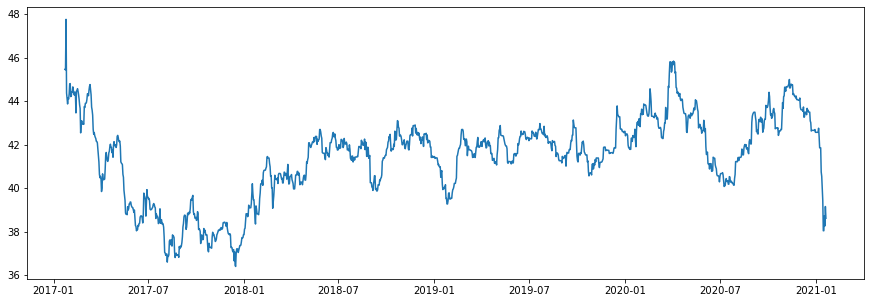

In [69]:
# Comparison with approval ratings (cf. PartII.4)
df_approval = pd.read_csv("data/approval_topline.csv")
df_approval = df_approval[df_approval.subgroup == "All polls"][["modeldate", "approve_estimate"]].iloc[::-1].reset_index(drop=True)
df_approval["modeldate"] = pd.to_datetime(df_approval["modeldate"])
from matplotlib.pyplot import figure
figure(figsize=(15, 5))
plt.plot(df_approval["modeldate"], df_approval["approve_estimate"])

### 4.2) Trump popularity and population groups   <a class="anchor" id="III.4.2"></a>

### Question 5: In which newspapers are Trump's quotations published? Is there a link between the newspapers that published the most quotations of Trump and the political affiliation of these newspapers?    <a class="anchor" id="III.5"></a>

First, we compute the `VaderCompound` for quotations from Trump. Then, we compute the set of all publishers by extracting the domain name from the `urls` field of the quotations about and from Trump. We then construct new dataframe, `publisher_from_df` and `publisher_about_df` which contain the number of quotations for each publisher, the `VaderCompound` scores and the associated means and confidence intervals.

In [10]:
preprocessed_df = pd.read_pickle('data/PreProcessData.pkl')
preprocessed_df.drop(['level_0', 'index'], axis=1, inplace=True)

In [17]:
Trump_from = preprocessed_df[preprocessed_df.speaker.str.lower().str.contains("trump")]
Trump_from.reset_index(drop=True, inplace=True)

In [22]:
# Analyser
analyzer = SentimentIntensityAnalyzer()

# Vader sentiment analysis
Trump_from.loc[:, 'Vader'] = Trump_from.quotation.apply(lambda x: analyzer.polarity_scores(x))

In [25]:
# Adding Vader sentiment analysis in a new dataframe
Trump_from_sentiment = Trump_from

# Column with Vader compound
Trump_from_sentiment.loc[:,'VaderCompound']  = Trump_from_sentiment.Vader.apply(lambda x: x['compound'])
# Column with final Vader sentiment
Trump_from_sentiment.loc[:,'VaderSentiment'] = Trump_from_sentiment.VaderCompound.apply(lambda x: 'POSITIVE' if x >=0 else 'NEGATIVE')

/home/eliot/miniconda3/envs/ada-main/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [27]:
Trump_from_sentiment.head(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote,Vader,VaderCompound,VaderSentiment
0,2015-07-17-029255,I am incredibly pleased that my message is res...,Donald Trump,"[Q22686, Q27947481]",2015-07-17 10:28:58,2,"[[Donald Trump, 0.8415], [None, 0.1356], [Rand...",[http://washingtontimes.com/news/2015/jul/17/d...,E,"[I, incredibly, pleased, message, resonating, ...","{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...",0.9272,POSITIVE
1,2015-12-10-038891,I don't want this person representing either t...,Donald Trump,"[Q22686, Q27947481]",2015-12-10 16:20:00,1,"[[Donald Trump, 0.509], [None, 0.491]]",[http://www.westernmorningnews.co.uk/Petition-...,E,"[I, want, person, representing, either, UK, US...","{'neg': 0.036, 'neu': 0.712, 'pos': 0.252, 'co...",0.8062,POSITIVE
2,2015-11-14-003251,And I will tell you what -- you can say what y...,Donald Trump,"[Q22686, Q27947481]",2015-11-14 22:45:14,6,"[[Donald Trump, 0.798], [None, 0.202]]",[http://news.yahoo.com/paris-wouldve-different...,E,"[And, I, tell, say, want, gun, people, gun, al...","{'neg': 0.0, 'neu': 0.965, 'pos': 0.035, 'comp...",0.0772,POSITIVE


In [28]:
Trump_from_sentiment.to_pickle("data/Trump_from_sentiment.pkl")

In [91]:
# To load the pickle file into pandas DataFrame
rump_about_sentiment = pd.read_pickle("data/Trump_about_sentiment.pkl")
# bootstrap function
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)
    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [30]:
def get_domains(urls):
    domains = []
    for url in urls:
        domain = urlparse(url).hostname.replace('www.', '')
        domains.append(domain)
    return domains

In [31]:
Trump_about_sentiment['domains'] = Trump_about_sentiment['urls'].apply(get_domains)
Trump_from_sentiment['domains'] = Trump_from_sentiment['urls'].apply(get_domains)
publishers_about = []
publishers_from = []
for pubs in Trump_about_sentiment['domains'].tolist():
    publishers_about.extend(pubs)
publishers_about = list(set(publishers_about))
for pubs in Trump_from_sentiment['domains'].tolist():
    publishers_from.extend(pubs)
publishers_from = list(set(publishers_from))

/tmp/ipykernel_11119/2233877445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trump_from_sentiment['domains'] = Trump_from_sentiment['urls'].apply(get_domains)


In [32]:
print(f'{len(publishers_about)} distinct publishers about Trump found.')
print(f'{len(publishers_from)} distinct publishers from Trump found.')

4813 distinct publishers about Trump found.
10573 distinct publishers from Trump found.


In [33]:
publisher_about_sets = [set([p]) for p in publishers_about]
publisher_from_sets = [set([p]) for p in publishers_from]

In [37]:
publisher_about_idx = [
    Trump_about_sentiment.domains.apply(pubset.issubset) for pubset in publisher_about_sets]
publisher_from_idx = [
    Trump_from_sentiment.domains.apply(pubset.issubset) for pubset in publisher_from_sets]

In [38]:
publisher_about_df = pd.DataFrame({
    'publisher': publishers_about,
    'num_quotations': [pubidx.sum() for pubidx in publisher_about_idx],
    'VaderCompound': [
        Trump_about_sentiment[pubidx].VaderCompound.values for pubidx in publisher_about_idx],
}).sort_values(by=['num_quotations'], ascending=False)

In [39]:
publisher_from_df = pd.DataFrame({
    'publisher': publishers_from,
    'num_quotations': [pubidx.sum() for pubidx in publisher_from_idx],
    'VaderCompound': [
        Trump_from_sentiment[pubidx].VaderCompound.values for pubidx in publisher_from_idx],
}).sort_values(by=['num_quotations'], ascending=False)

In [48]:
publisher_about_df['average_VaderCompound'] = publisher_about_df.VaderCompound.apply(lambda x: x.mean())
CI_about = publisher_about_df.VaderCompound.apply(lambda x: bootstrap_CI(x, 1000))
upper_CI_about = CI_about.apply(lambda x: x[1])
lower_CI_about = CI_about.apply(lambda x: x[0])
publisher_about_df['lower_err_VaderCompound'] = upper_CI_about
publisher_about_df['upper_err_VaderCompound'] = lower_CI_about

In [50]:
publisher_from_df['average_VaderCompound'] = publisher_from_df.VaderCompound.apply(lambda x: x.mean())
CI_from = publisher_from_df.VaderCompound.apply(lambda x: bootstrap_CI(x, 1000))
upper_CI_from = CI_from.apply(lambda x: x[1])
lower_CI_from = CI_from.apply(lambda x: x[0])
publisher_from_df['lower_err_VaderCompound'] = upper_CI_from
publisher_from_df['upper_err_VaderCompound'] = lower_CI_from

In [51]:
publisher_about_df.head(3)

,publisher,num_quotations,VaderCompound,average_VaderCompound,lower_err_VaderCompound,upper_err_VaderCompound
1085,breitbart.com,201,"[-0.4588, 0.34, -0.9818, -0.9788, 0.4939, -0.9...",0.020253,0.097387,-0.064663
3427,msn.com,185,"[0.6124, 0.7184, 0.9538, -0.7178, -0.8402, 0.1...",0.148655,0.220558,0.069749
2673,washingtontimes.com,99,"[0.1531, 0.7902, -0.8402, 0.4588, 0.9136, 0.41...",0.085853,0.182011,-0.016822


In [52]:
publisher_from_df.head(3)

,publisher,num_quotations,VaderCompound,average_VaderCompound,lower_err_VaderCompound,upper_err_VaderCompound
3290,breitbart.com,43693,"[-0.6486, -0.1761, -0.0772, 0.1901, 0.4404, 0....",0.075750,0.080262,0.070962
9824,msn.com,41029,"[0.8752, -0.1761, -0.0772, -0.4939, 0.0, 0.493...",0.058239,0.063193,0.053643
6166,thehill.com,23069,"[0.0, 0.1901, 0.6249, -0.4019, 0.0, 0.0772, 0....",0.068189,0.074390,0.061839


In [53]:
publisher_about_df.to_pickle("data/publisher_about_df.pkl")
publisher_from_df.to_pickle("data/publisher_from_df.pkl")

In [13]:
publisher_about_df = pd.read_pickle("data/publisher_about_df.pkl")
publisher_from_df = pd.read_pickle("data/publisher_from_df.pkl")

### 5.1) In which newspaper are Trump's quotations published ? <a class="anchor" id="III.4.2"></a>

There are 4813 distinct publishers for quotation about Trump and 10573 for quotations from Trump. To get an idea of these publishers, we plot the histogram of the number of quotations.

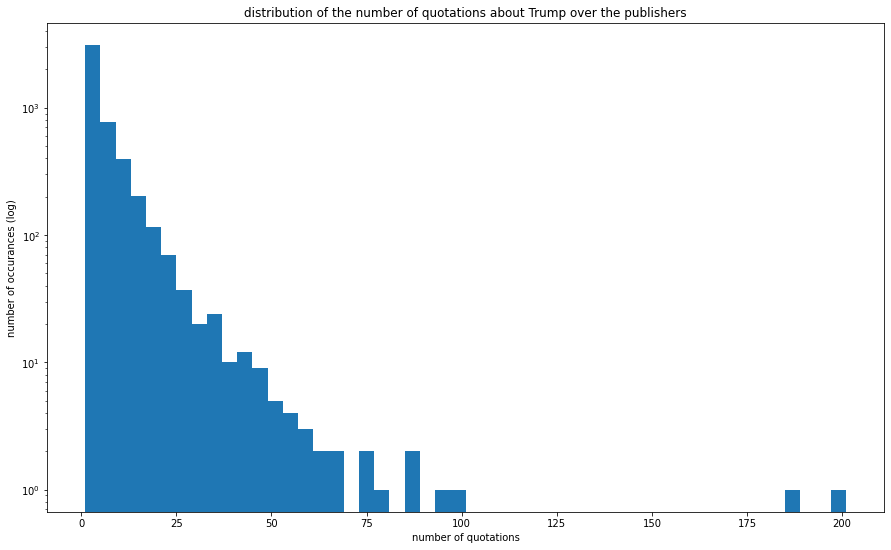

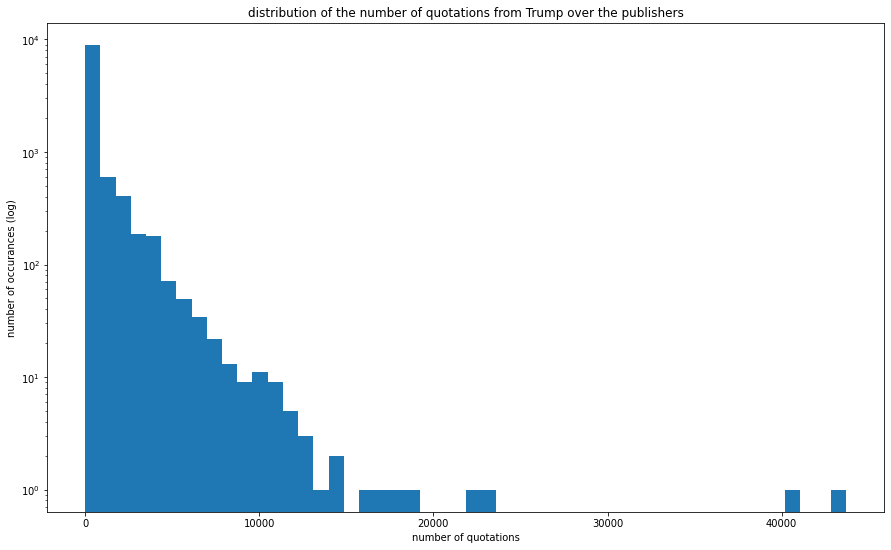

In [14]:
figure(figsize=(15, 9))
plt.hist(publisher_about_df.num_quotations, log=True, bins=50)
plt.xlabel('number of quotations')
plt.ylabel('number of occurances (log)')
plt.title('distribution of the number of quotations about Trump over the publishers')
plt.show()
figure(figsize=(15, 9))
plt.hist(publisher_from_df.num_quotations, log=True, bins=50)
plt.xlabel('number of quotations')
plt.ylabel('number of occurances (log)')
plt.title('distribution of the number of quotations from Trump over the publishers')
plt.show()

We observe that the distributions are even more skew than a heavy-tail distribution. This means that there are many publishers with few quotations and a few publishers with many quotations. Let's list the 10 most important publishers in terms of number of quotations.

In [15]:
k = 10
top_k_publishers_about = publisher_about_df[:k].reset_index(drop=True)
top_k_publishers_from = publisher_from_df[:k].reset_index(drop=True)

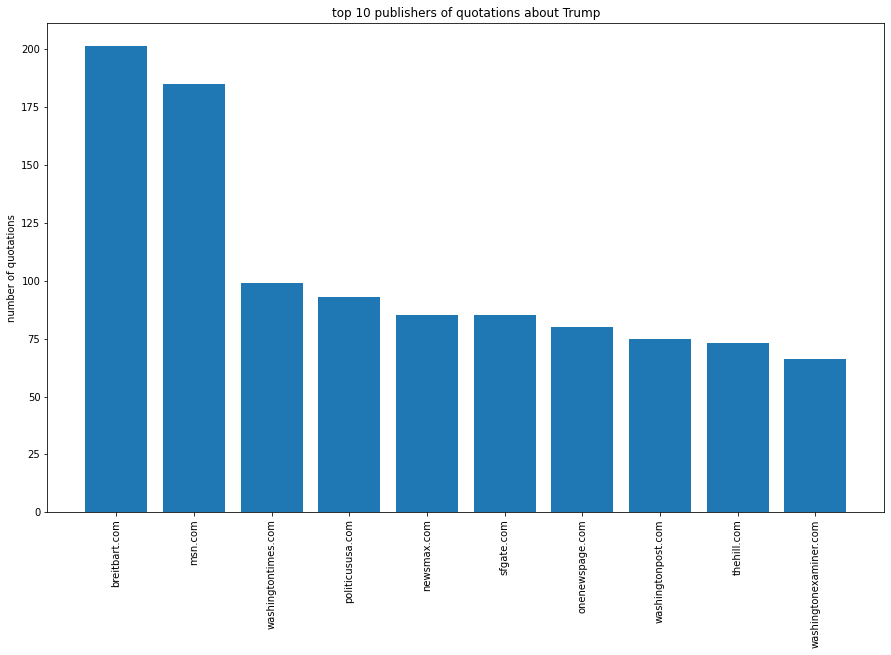

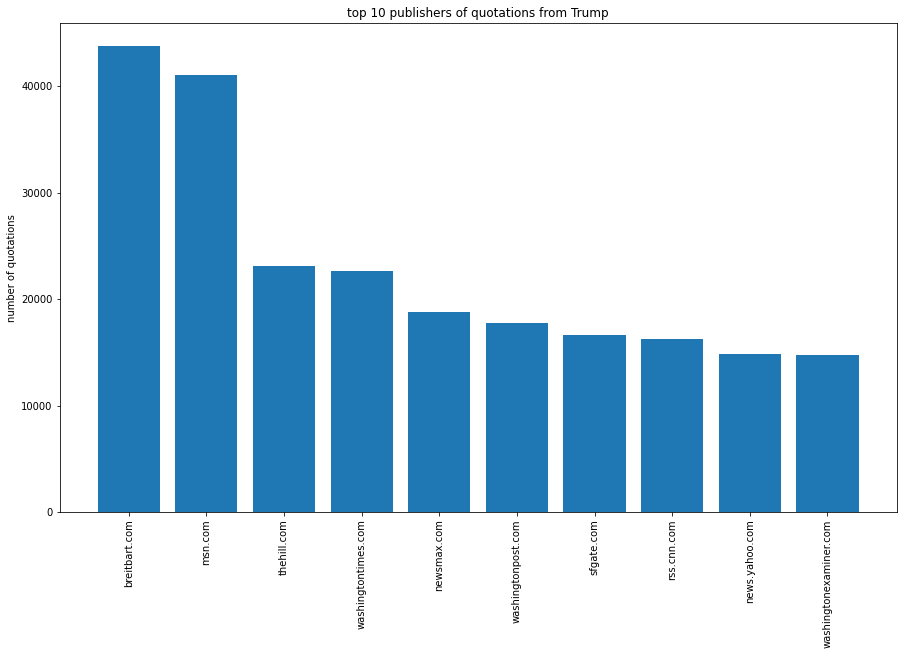

In [16]:
ticks = np.arange(k)
figure(figsize=(15, 9))
plt.bar(ticks, top_k_publishers_about.num_quotations)
plt.xticks(ticks, top_k_publishers_about.publisher.tolist(), rotation=90)
plt.ylabel('number of quotations')
plt.title(f'top {k} publishers of quotations about Trump')
plt.show()
figure(figsize=(15, 9))
plt.bar(ticks, top_k_publishers_from.num_quotations)
plt.xticks(ticks, top_k_publishers_from.publisher.tolist(), rotation=90)
plt.ylabel('number of quotations')
plt.title(f'top {k} publishers of quotations from Trump')
plt.show()

In [17]:
print('about:\n',top_k_publishers_about[['publisher', 'num_quotations']])
print('from:\n',top_k_publishers_from[['publisher', 'num_quotations']])

about:
                 publisher  num_quotations
0           breitbart.com             201
1                 msn.com             185
2     washingtontimes.com              99
3        politicususa.com              93
4             newsmax.com              85
5              sfgate.com              85
6         onenewspage.com              80
7      washingtonpost.com              75
8             thehill.com              73
9  washingtonexaminer.com              66
from:
                 publisher  num_quotations
0           breitbart.com           43693
1                 msn.com           41029
2             thehill.com           23069
3     washingtontimes.com           22685
4             newsmax.com           18835
5      washingtonpost.com           17724
6              sfgate.com           16615
7             rss.cnn.com           16283
8          news.yahoo.com           14826
9  washingtonexaminer.com           14802


Let's look at these publishers:
- **breitbart** is an American **far-right** syndicated news, opinion and commentary website. <a href='https://en.wikipedia.org/wiki/Breitbart_News'>(Wikipedia)</a>
- **msn.com** is a web portal and related collection of internet services and apps owned by Microsoft. <a href='https://en.wikipedia.org/wiki/MSN'>(Wikipedia)</a> It features news headlines and articles chosen by the editors.
- **The Washington Times** is an American **conservative** daily newspaper published in Washington, D.C. <a href='https://en.wikipedia.org/wiki/The_Washington_Times'>(Wikipedia)</a>
- **politicucusa.com** describes itself as a provider of news, commentary and opinion from a **liberal** point of view independently from any political affiliation. <a href='https://www.politicususa.com/about-us'>(website)</a>
- **SFGate** is **left-center** news website, created by the San Franscisco Chronicle in 1994. They are now two separated entites. <a href='https://en.wikipedia.org/wiki/San_Francisco_Chronicle'>(Wikipedia)</a>
- **newsmax** is a **conservative** American news and opinion website founded by Christopher Ruddy on September 16, 1998, and operated by Newsmax Media. <a href='https://en.wikipedia.org/wiki/Newsmax'>(Wikipedia)</a>
- **onenewspage** describes itself as providing of a one-stop view of breaking news, video coverage by reputable broadcast outlets, a powerful search engine and the ability to view related news headlines and news videos on the same page. <a href='https://www.onenewspage.com/aboutus.php'>(website)</a>
- **The Washington post** is a **liberal-leaning** daily American newspaper published in Washington, D.C. <a href='https://en.wikipedia.org/wiki/The_Washington_Post'>(Wikipedia)</a>
- **The Hill** is a **nonpartisan** American media company based in Washington, D.C focusing on politics, policy, buisness and international relations. <a href='https://en.wikipedia.org/wiki/The_Hill_(newspaper)'>(Wikipedia)</a>
- **The Washington Examiner** is an American **conservative** news website and weekly magazine based in Washington, D.C. <a href='https://en.wikipedia.org/wiki/Washington_Examiner'>(Wikipedia)</a>
- **The New York Times** is a **left-center** an American daily newspaper published in New York. <a href='https://en.wikipedia.org/wiki/The_New_York_Times'>(Wikipedia)</a>
- **Cable News Network (CNN)** is a multinational news-based pay television channel headquartered in Atlanta, United States. It is politcally **left-leaning**. <a href='https://en.wikipedia.org/wiki/CNN'>(Wikipedia)</a>
- **Yahoo! News** is a **left-leaning** news website that originated as an internet-based news aggregator by Yahoo!. <a href='https://en.wikipedia.org/wiki/Yahoo!_News'>(Wikipedia)</a> 

In [19]:
affiliation_dict = {
    'breitbart.com': 'conservative',
    'msn.com': 'non-affiliated',
    'washingtontimes.com': 'conservative',
    'politicususa.com': 'liberal',
    'newsmax.com': 'conservative',
    'sfgate.com': 'liberal',
    'onenewspage.com': 'non-affiliated',
    'washingtonpost.com': 'liberal',
    'thehill.com': 'non-affiliated',
    'washingtonexaminer.com': 'conservative',
    'rss.cnn.com': 'liberal',
    'news.yahoo.com': 'liberal'
}
liberal = 0
conservative = 0
na = 0
for val in affiliation_dict.values():
    if val == 'liberal': liberal += 1
    elif val == 'conservative': conservative += 1
    else: na += 1
print(f'top {k} from and about Trump contain:')
print(f'- {conservative} conservative publishers')
print(f'- {liberal} liberal publishers')
print(f'- {na} non-affliated publishers')

top 10 from and about Trump contain:
- 4 conservative publishers
- 5 liberal publishers
- 3 non-affliated publishers


In general, these publishers are mostly but not exclusively based in the United States and seems to be balanced in term of political stance. We note that the most important publisher is a far-right website. Additionally, Fox News, which is well known to be friendly with Donald Trump does not appear in the top 10.

### 5.2) Is there a link between the newspapers that published the most quotations of Trump and the political affiliation of these newspapers?

In this section we investigate the relation between the number of quotations about Trump and the political affiliation of the newspapers.

We start this analysis by visualizing all the publishers on a scatter plot. The x-axis is the number of quotations and the y-axis the average `VaderCompound` score.

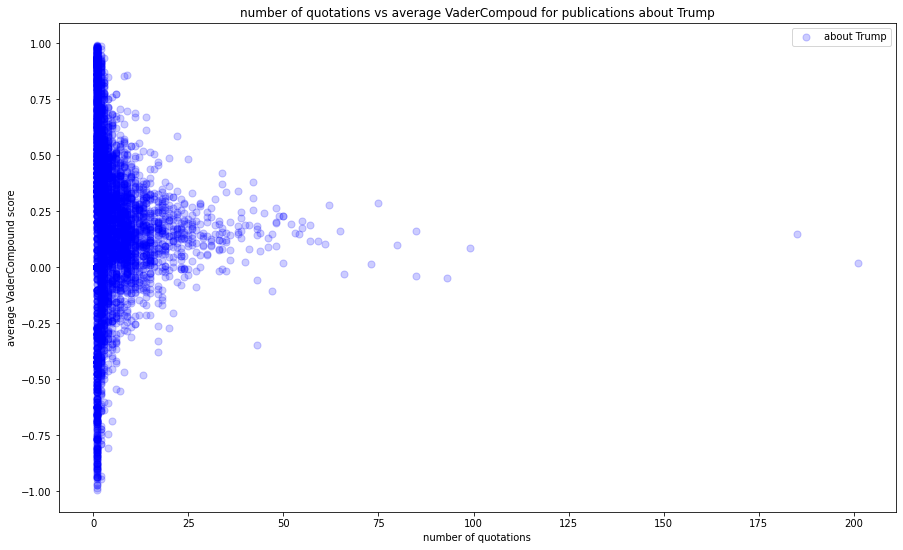

In [20]:
ax = publisher_about_df.plot.scatter(x='num_quotations', 
                                     y='average_VaderCompound',
                                     s=50,
                                     figsize=(15,9),
                                     c='b',
                                     alpha=0.2,
                                     label='about Trump')
ax.set_xlabel('number of quotations')
ax.set_ylabel('average VaderCompound score')
ax.set_title('number of quotations vs average VaderCompoud for publications about Trump')
plt.legend()
plt.show()

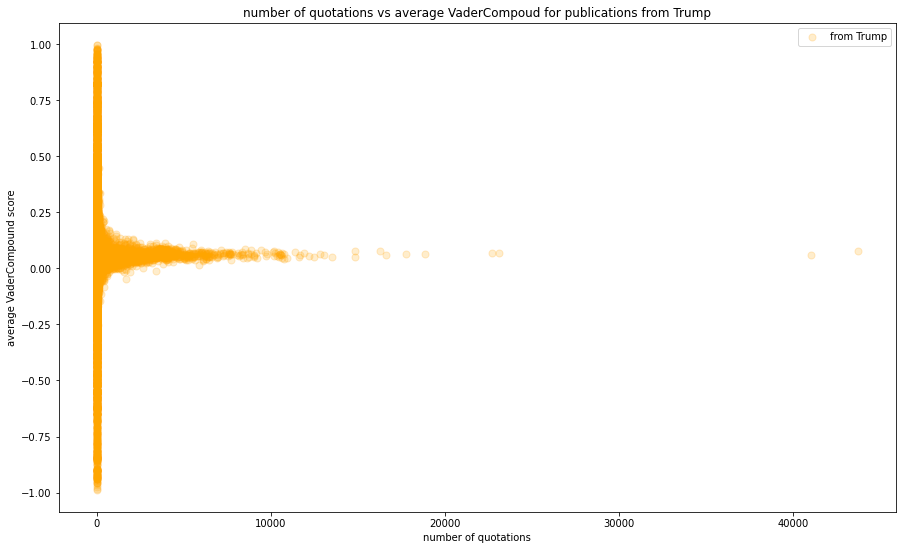

In [21]:
ax=publisher_from_df.plot.scatter(x='num_quotations', 
                               y='average_VaderCompound',
                               s=50,
                               figsize=(15,9),
                               c='orange',
                               alpha=0.2,
                               label='from Trump')
ax.set_xlabel('number of quotations')
ax.set_ylabel('average VaderCompound score')
ax.set_title('number of quotations vs average VaderCompoud for publications from Trump')
plt.legend()
plt.show()

This plot shows that most publishers relay, on average, neutral quotations about Trump. We see that extreme opinions occur often for publishers with low number of quotations and become more and more rare the more quotations are published. This phenomenon could be explained by the fact that the less quotations, the less accurate the empirical mean. For publishers with very low quotation count, we may simply have a single extreme quotation which is not representative of the editorial line.

Next, we study the top-15 publishers again. We show below a bar plot of their average `VaderCompund` with error bars corresponding the bootstrapped confidence interval. Combining this information with the research done in point 5.1 about the publishers, we should get an idea of the type of quotations these publishers choose to relay. After that we can try to correlate this with their political affiliation. Additionally, we plot the conservatives, progressists and non-affiliated in different colors.

In [40]:
top_k_publishers_about['affiliation'] = top_k_publishers_about['publisher'].apply(lambda x: affiliation_dict[x])
top_k_publishers_from['affiliation'] = top_k_publishers_from['publisher'].apply(lambda x: affiliation_dict[x])
top_k_publishers_from.sort_values(by=['average_VaderCompound'], ascending=False, inplace=True)
top_k_publishers_about.sort_values(by=['average_VaderCompound'], ascending=False, inplace=True)

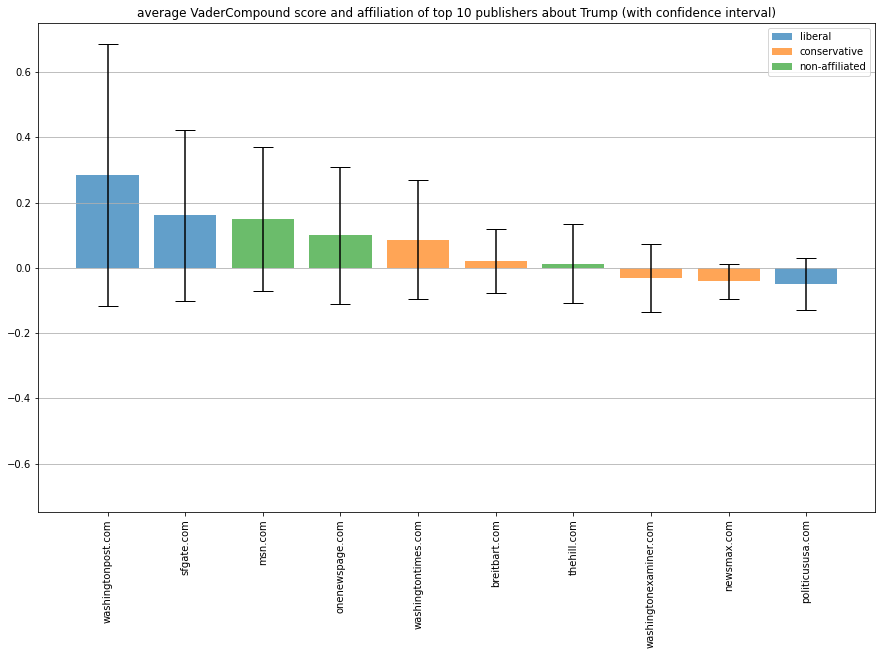

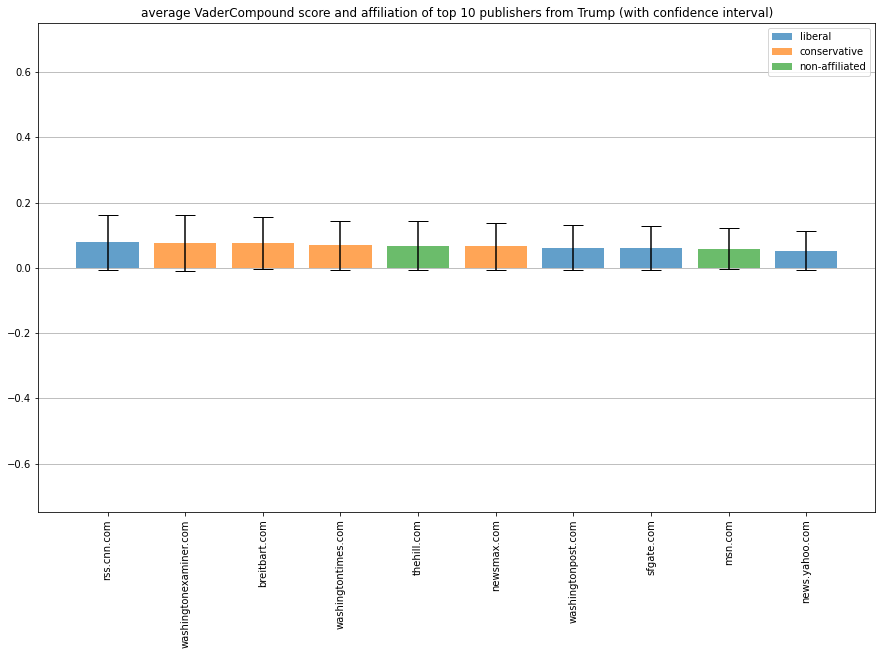

In [41]:
ticks = np.arange(k)
fig, ax = plt.subplots(figsize=(15, 9))
for aff in set(affiliation_dict.values()):
    idx = top_k_publishers_about.affiliation==aff
    tmp = top_k_publishers_about[idx]
    t = ticks[idx]
    errs = np.concatenate([tmp.lower_err_VaderCompound.values.reshape(-1,1), 
                       tmp.lower_err_VaderCompound.values.reshape(-1,1)], axis=1).T
    ax.bar(t, 
           tmp.average_VaderCompound,
           yerr=errs,
           label=aff,
           align='center', 
           alpha=0.7, 
           ecolor='black', 
           capsize=10)
ax.set_title(f'average VaderCompound score and affiliation of top {k} publishers about Trump (with confidence interval)')
ax.set_xticks(ticks)
ax.set_xticklabels(top_k_publishers_about.publisher, rotation=90)
ax.set_ylim((-.75,.75))
ax.yaxis.grid(True)
plt.legend()
plt.show()

ticks = np.arange(k)
fig, ax = plt.subplots(figsize=(15, 9))
for aff in set(affiliation_dict.values()):
    idx = top_k_publishers_from.affiliation==aff
    tmp = top_k_publishers_from[idx]
    t = ticks[idx]
    errs = np.concatenate([tmp.lower_err_VaderCompound.values.reshape(-1,1), 
                       tmp.lower_err_VaderCompound.values.reshape(-1,1)], axis=1).T
    ax.bar(t, 
           tmp.average_VaderCompound,
           yerr=errs,
           label=aff,
           align='center', 
           alpha=0.7, 
           ecolor='black', 
           capsize=10)
ax.set_title(f'average VaderCompound score and affiliation of top {k} publishers from Trump (with confidence interval)')
ax.set_xticks(ticks)
ax.set_xticklabels(top_k_publishers_from.publisher, rotation=90)
ax.set_ylim((-.75,.75))
ax.yaxis.grid(True)
plt.legend()
plt.show()

The results are quite counter-intuitive. For quotations about Trump, the highest average scores are produced by the more liberal publishers. And the far-right publisher, breitbart, does not even achieve a particularly high score. Howver, when considering the confidence intervals, these consideration should be taken carefully as the ranking could completly change. For the quotations from Trump, the highest ranked media outlet is considered liberal but is followed by most of the conservative ones, which would be expected. We also observe that most publishers seem to converge to an average score around 0.1. These considerations could be caused and influenced by multiple factors such as press self-censorship or respect towards the president, inaccurate sentiment analysis or lack of correlation between political affiliation and quotations about or from Trump. 

In general, it seems that there is no correlation between the political affiliation and the kind of quotes cited by a publisher. Even Fox News, which is known to be highly sympathetic towards Donald Trump has a very moderate score.

In [84]:
fox_about = publisher_about_df[publisher_about_df.publisher=='foxnews.com'].average_VaderCompound.values[0]
fox_from = publisher_from_df[publisher_from_df.publisher=='foxnews.com'].average_VaderCompound.values[0]
print(f'Fox News average VaderCompound: {fox_about} (about), {fox_from} (from)')

Fox News average VaderCompound: 0.1481 (about), 0.04602290413533835 (from)


Note that these publishers are all at the right end of the `num_quotations` vs `average_VaderCompound` plot that we showed above. To get a better idea of the situation, we will select the publishers based on the average vader compound. We will choose the 3 highest, 3 lowest and 3 around the median, search for their affiliation and repeat the analysis made above.

```python
n = 3
publisher_about_df.sort_values(by=['average_VaderCompound'], ascending=False, inplace=True)
publisher_from_df.sort_values(by=['average_VaderCompound'], ascending=False, inplace=True)

about_median = publisher_about_df.average_VaderCompound.median()
from_median = publisher_from_df.average_VaderCompound.median()
about_median_idx = publisher_about_df.average_VaderCompound.sub(about_median).abs().argsort()[:n]
from_median_idx = publisher_from_df.average_VaderCompound.sub(from_median).abs().argsort()[:n]

publisher_about_buckets = pd.concat([
    publisher_about_df[:n],
    publisher_about_df.iloc[about_median_idx],
    publisher_about_df[-n:]
], ignore_index=True)

publisher_from_buckets = pd.concat([
    publisher_from_df[:n],
    publisher_from_df.iloc[from_median_idx],
    publisher_from_df[-n:]
], ignore_index=True)

res_publishers = set(publisher_about_buckets.publisher.tolist()+publisher_from_buckets.publisher.tolist())
res_publishers
```

Let's look at these publishers' affiliation:
- **america wake up to truth** is no longer available to violation of terms of service of WordPress.
- **AOL** is a british news website considered **left-centered**.
- **baylor lariat** is a **left-leaning** student to student new website in the US.
- **Dunfermline Press** is a weekly Scottish tabloid newspaper, based in Dunfermline, Fife which mostly focuses on local news.
- **Florence20** seem to be a news blog dedicated to technology.
- **Footbal Real Game** is a football news, rumors and analysis forum